In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.linear_model import LogisticRegression # Works
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # Works
from sklearn.neighbors import KNeighborsClassifier # Works
from sklearn.naive_bayes import GaussianNB # Works
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy, specificity_score
from sklearn.preprocessing import LabelEncoder
from numpy import average
from sklearn.multioutput import MultiOutputClassifier
from sklearn.exceptions import ConvergenceWarning
import warnings
from imblearn.over_sampling import SMOTE, RandomOverSampler, KMeansSMOTE
from imblearn.under_sampling import ClusterCentroids, CondensedNearestNeighbour, EditedNearestNeighbours, RandomUnderSampler
from matplotlib.pyplot import figure
import matplotlib.ticker as ticker

le = LabelEncoder()

SEED = 42
DATA_STRUCTURE = json.load(open('data_structure.json'))
DATA_KEYS = list(DATA_STRUCTURE.keys())
CLASSIFIERS = {
  "GaussianNB":GaussianNB,
  "LinearDiscriminantAnalysis":LinearDiscriminantAnalysis,
  "KNeighborsClassifier":KNeighborsClassifier,
  "DecisionTreeClassifier":DecisionTreeClassifier,
  "LogisticRegression": LogisticRegression,
  # "SVC":SVC
  # Random forrest 
}
OUTPUT_COLS = ['dataset', 'target', 'target_name', 'avg_precision', 'precision_folds', 'avg_recall', 'recall_folds', 'avg_f1', 'f1_folds', 'avg_geometric_mean', 'geometric_mean_folds','avg_specificity','specificity_folds']


In [64]:
complexityDF = pd.read_csv(f'./out/complexityDF.csv', index_col=0)

complexityDFColumns = ['dataset','target1','target2', 'target3']
complexityDF.columns = complexityDFColumns
meltedComplexityDF = pd.melt(complexityDF, value_vars=['target1','target2', 'target3'], var_name='Target', id_vars=['dataset'])
meltedComplexityDF= meltedComplexityDF.sort_values(by=['value'], ignore_index=True)
chunks = np.array_split(meltedComplexityDF, 3)
finalComplexityDF = pd.DataFrame({})
for i, chunk in enumerate(chunks):
  chunk['chunk'] = [i]*len(chunk)
  labels = []
  for i in range(len(chunk['Target'].values)):
    labels.append(chunk['dataset'].values[i][0:3] + '_' +  chunk['Target'].values[i][-2:])
  # print('------------------------------------------------')
  finalComplexityDF = pd.concat((finalComplexityDF, chunk))
# print(finalComplexityDF)


In [65]:
aggregateMetrics = {}
aggregateStandardDev = {}
for name in CLASSIFIERS:
  df = pd.read_csv(f'./out//{name}.csv')
  result = df.groupby('target')[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean']].mean()

  standardDev = df.groupby('target')[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',]].std()
  aggregateStandardDev[name] = standardDev
  aggregateMetrics[name] = result

aggregateMetricsAdjustedt1 = {}
aggregateStandardDevAdjustedt1 = {}
for name in CLASSIFIERS:
  df = pd.read_csv(f'./out/balanced-target1/{name}.csv')
  result = df.groupby('target')[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',]].mean()
  adjustedStandardDev = df.groupby('target')[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',]].std()

  aggregateMetricsAdjustedt1[name] = result
  aggregateStandardDevAdjustedt1[name] = adjustedStandardDev

aggregateMetricsAdjustedt1t2 = {}
aggregateStandardDevAdjustedt1t2 = {}
for name in CLASSIFIERS:
  df = pd.read_csv(f'./out/balanced-target1-target2/{name}.csv')
  result = df.groupby('target')[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',]].mean()
  adjustedStandardDev = df.groupby('target')[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',]].std()

  aggregateMetricsAdjustedt1[name] = result
  aggregateStandardDevAdjustedt1[name] = adjustedStandardDev


aggregateMetricsAdjustedAllMetrics = {}
aggregateStandardDevAdjustedAllMetrics = {}
for name in CLASSIFIERS:
  df = pd.read_csv(f'./out/balanced-target1-target2-target3/{name}.csv')
  result = df.groupby('target')[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',]].mean()
  adjustedStandardDev = df.groupby('target')[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',]].std()

  aggregateMetricsAdjustedAllMetrics[name] = result
  aggregateStandardDevAdjustedAllMetrics[name] = adjustedStandardDev

allAggregatePerformances = {
  "Original": (aggregateMetrics,aggregateStandardDev, 'bo'),
  "Adjusted for target 1": (aggregateMetricsAdjustedt1, aggregateStandardDevAdjustedt1, 'ro'),
  "Adjusted for targets 1 & 2": (aggregateMetricsAdjustedt1t2, aggregateStandardDevAdjustedt1t2, 'ro'),
  "Adjusted for targets 1, 2 & 3": (aggregateMetricsAdjustedAllMetrics, aggregateStandardDevAdjustedAllMetrics, 'go')
}

performances = [aggregateMetrics, aggregateMetricsAdjustedt1, aggregateMetricsAdjustedt1t2, aggregateMetricsAdjustedAllMetrics]

# print(allAggregatePerformances['Adjusted for targets 1, 2 & 3'][1])

In [81]:
aggregateMetrics = {}
aggregateStandardDev = {}

for name in CLASSIFIERS:
  df = pd.read_csv(f'./out/{name}.csv')
  result = df.groupby(['dataset', 'target'], as_index = False)[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean']].mean()
  standardDev = df.groupby(['dataset', 'target'], as_index = False)[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',]].std()
  aggregateMetrics[name] = result
  aggregateStandardDev[name] = standardDev


aggregateMetricst1 = {}
aggregateStandardDevt1 = {}

for name in CLASSIFIERS:
  df = pd.read_csv(f'./out/balanced-target1/{name}.csv')
  result = df.groupby(['dataset', 'target'], as_index = False)[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean']].mean()
  standardDev = df.groupby(['dataset', 'target'], as_index = False)[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',]].std()
  aggregateMetricst1[name] = result
  aggregateStandardDevt1[name] = standardDev


aggregateMetricst1t2 = {}
aggregateStandardDevt1t2 = {}

for name in CLASSIFIERS:
  df = pd.read_csv(f'./out/balanced-target1-target2/{name}.csv')
  result = df.groupby(['dataset', 'target'], as_index = False)[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean']].mean()
  standardDev = df.groupby(['dataset', 'target'], as_index = False)[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',]].std()
  aggregateMetricst1t2[name] = result
  aggregateStandardDevt1t2[name] = standardDev
  

aggregateMetricst1t2t3 = {}
aggregateStandardDevt1t2t3 = {}

for name in CLASSIFIERS:
  df = pd.read_csv(f'./out/balanced-target1-target2-target3/{name}.csv')
  result = df.groupby(['dataset', 'target'], as_index = False)[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean']].mean()
  standardDev = df.groupby(['dataset', 'target'], as_index = False)[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean',]].std()
  aggregateMetricst1t2t3[name] = result
  aggregateStandardDevt1t2t3[name] = standardDev



allAggregatePerformances = {
  "Original": (aggregateMetrics,aggregateStandardDev, 'bo'),
  "Adjusted for target 1": (aggregateMetricst1, aggregateStandardDevt1, 'ro'),
  "Adjusted for target 1 and target 2": (aggregateMetricst1t2, aggregateStandardDevt1t2, 'ko'),
  "Adjusted for all targets": (aggregateMetricst1t2t3, aggregateStandardDevt1t2t3, 'go')
}


<Figure size 2500x2500 with 0 Axes>

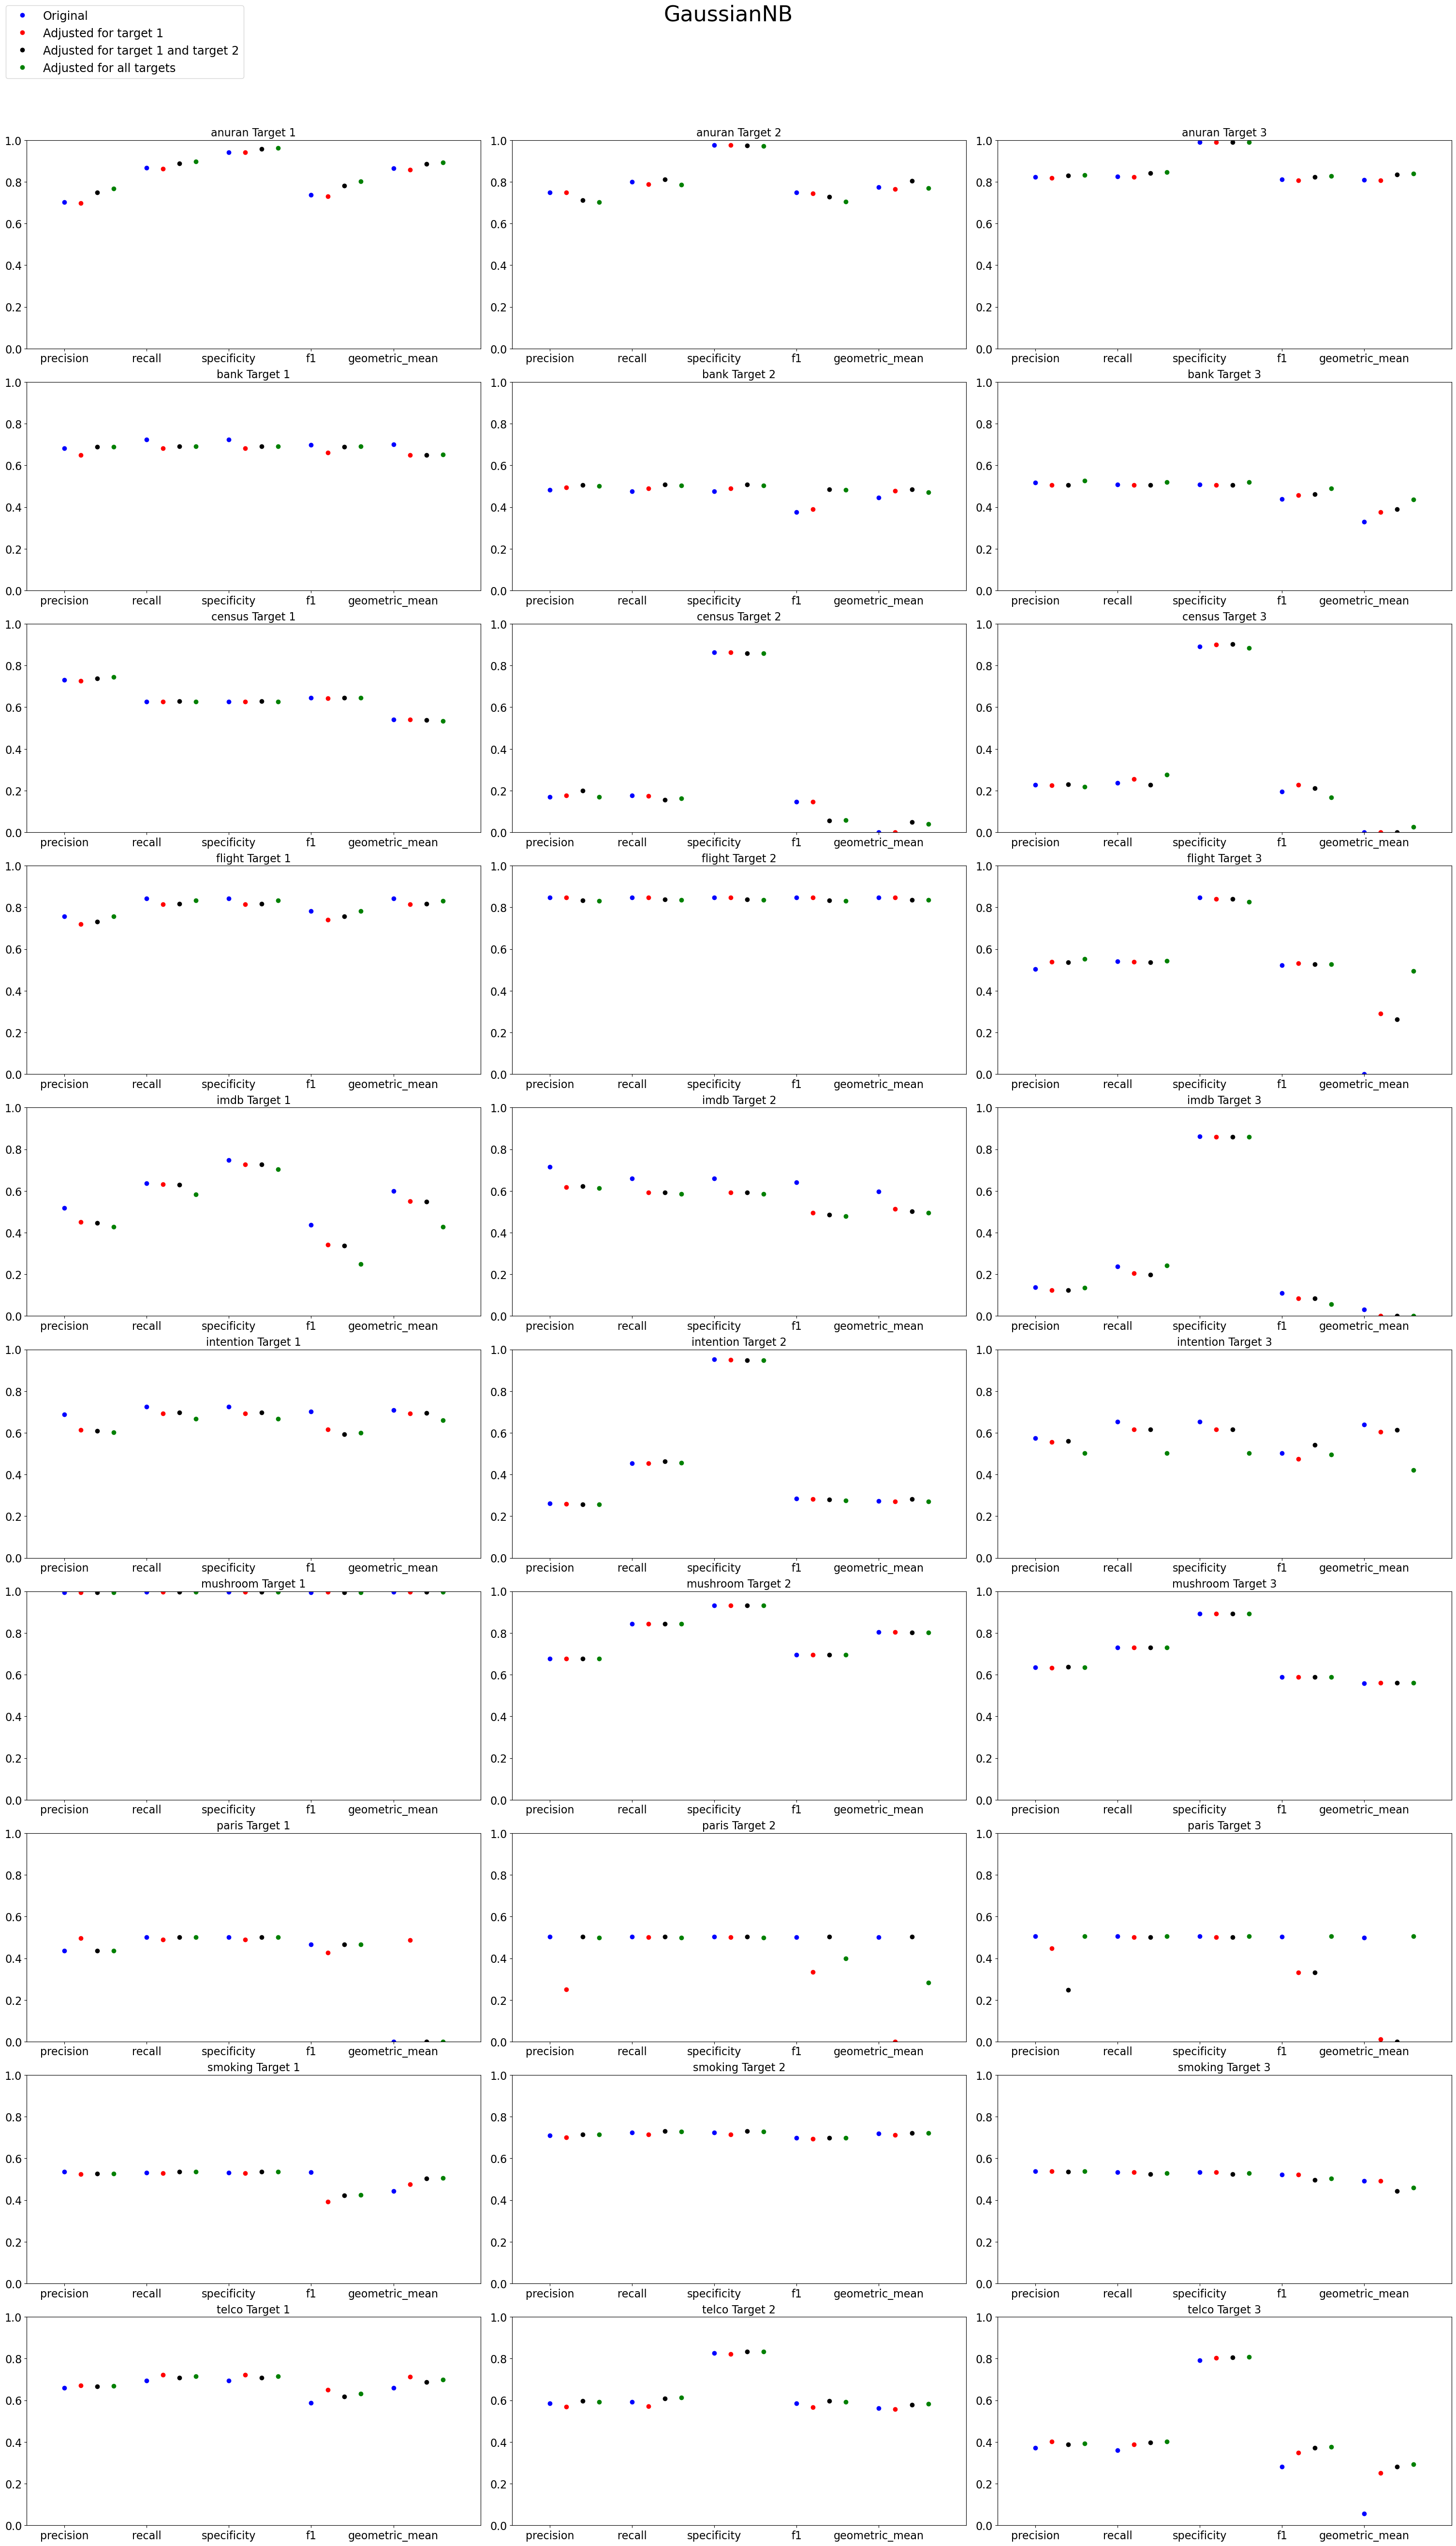

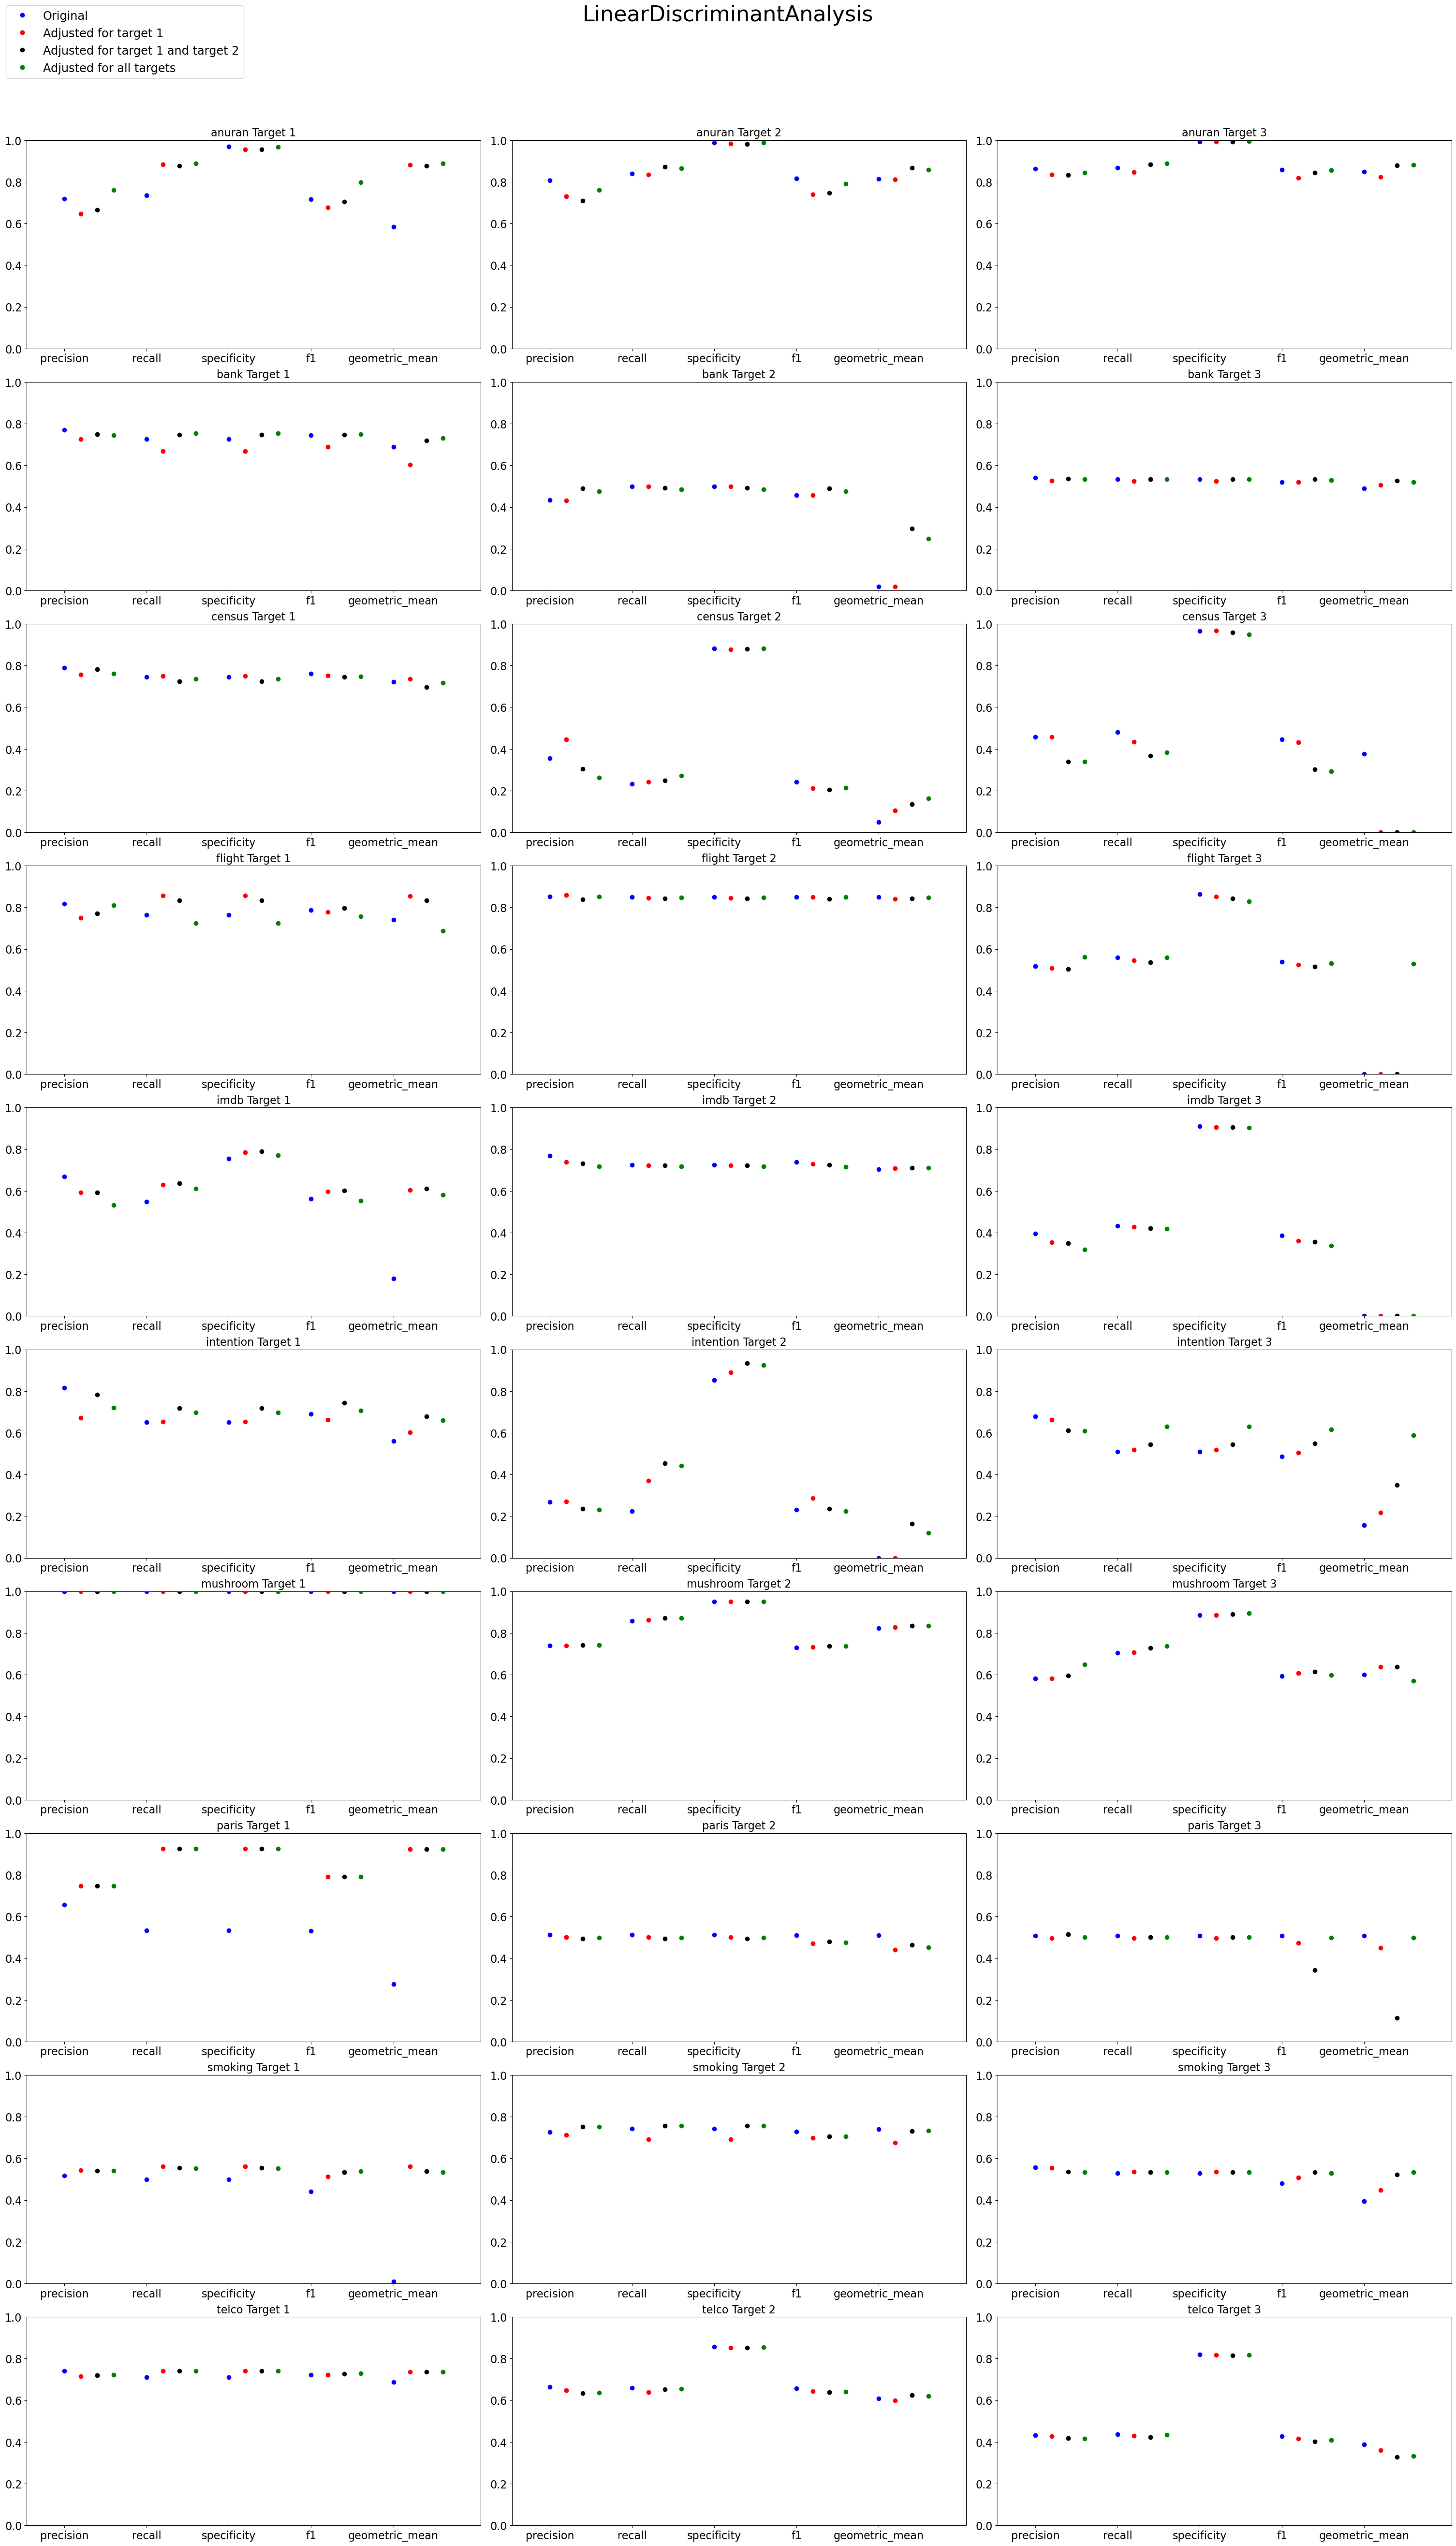

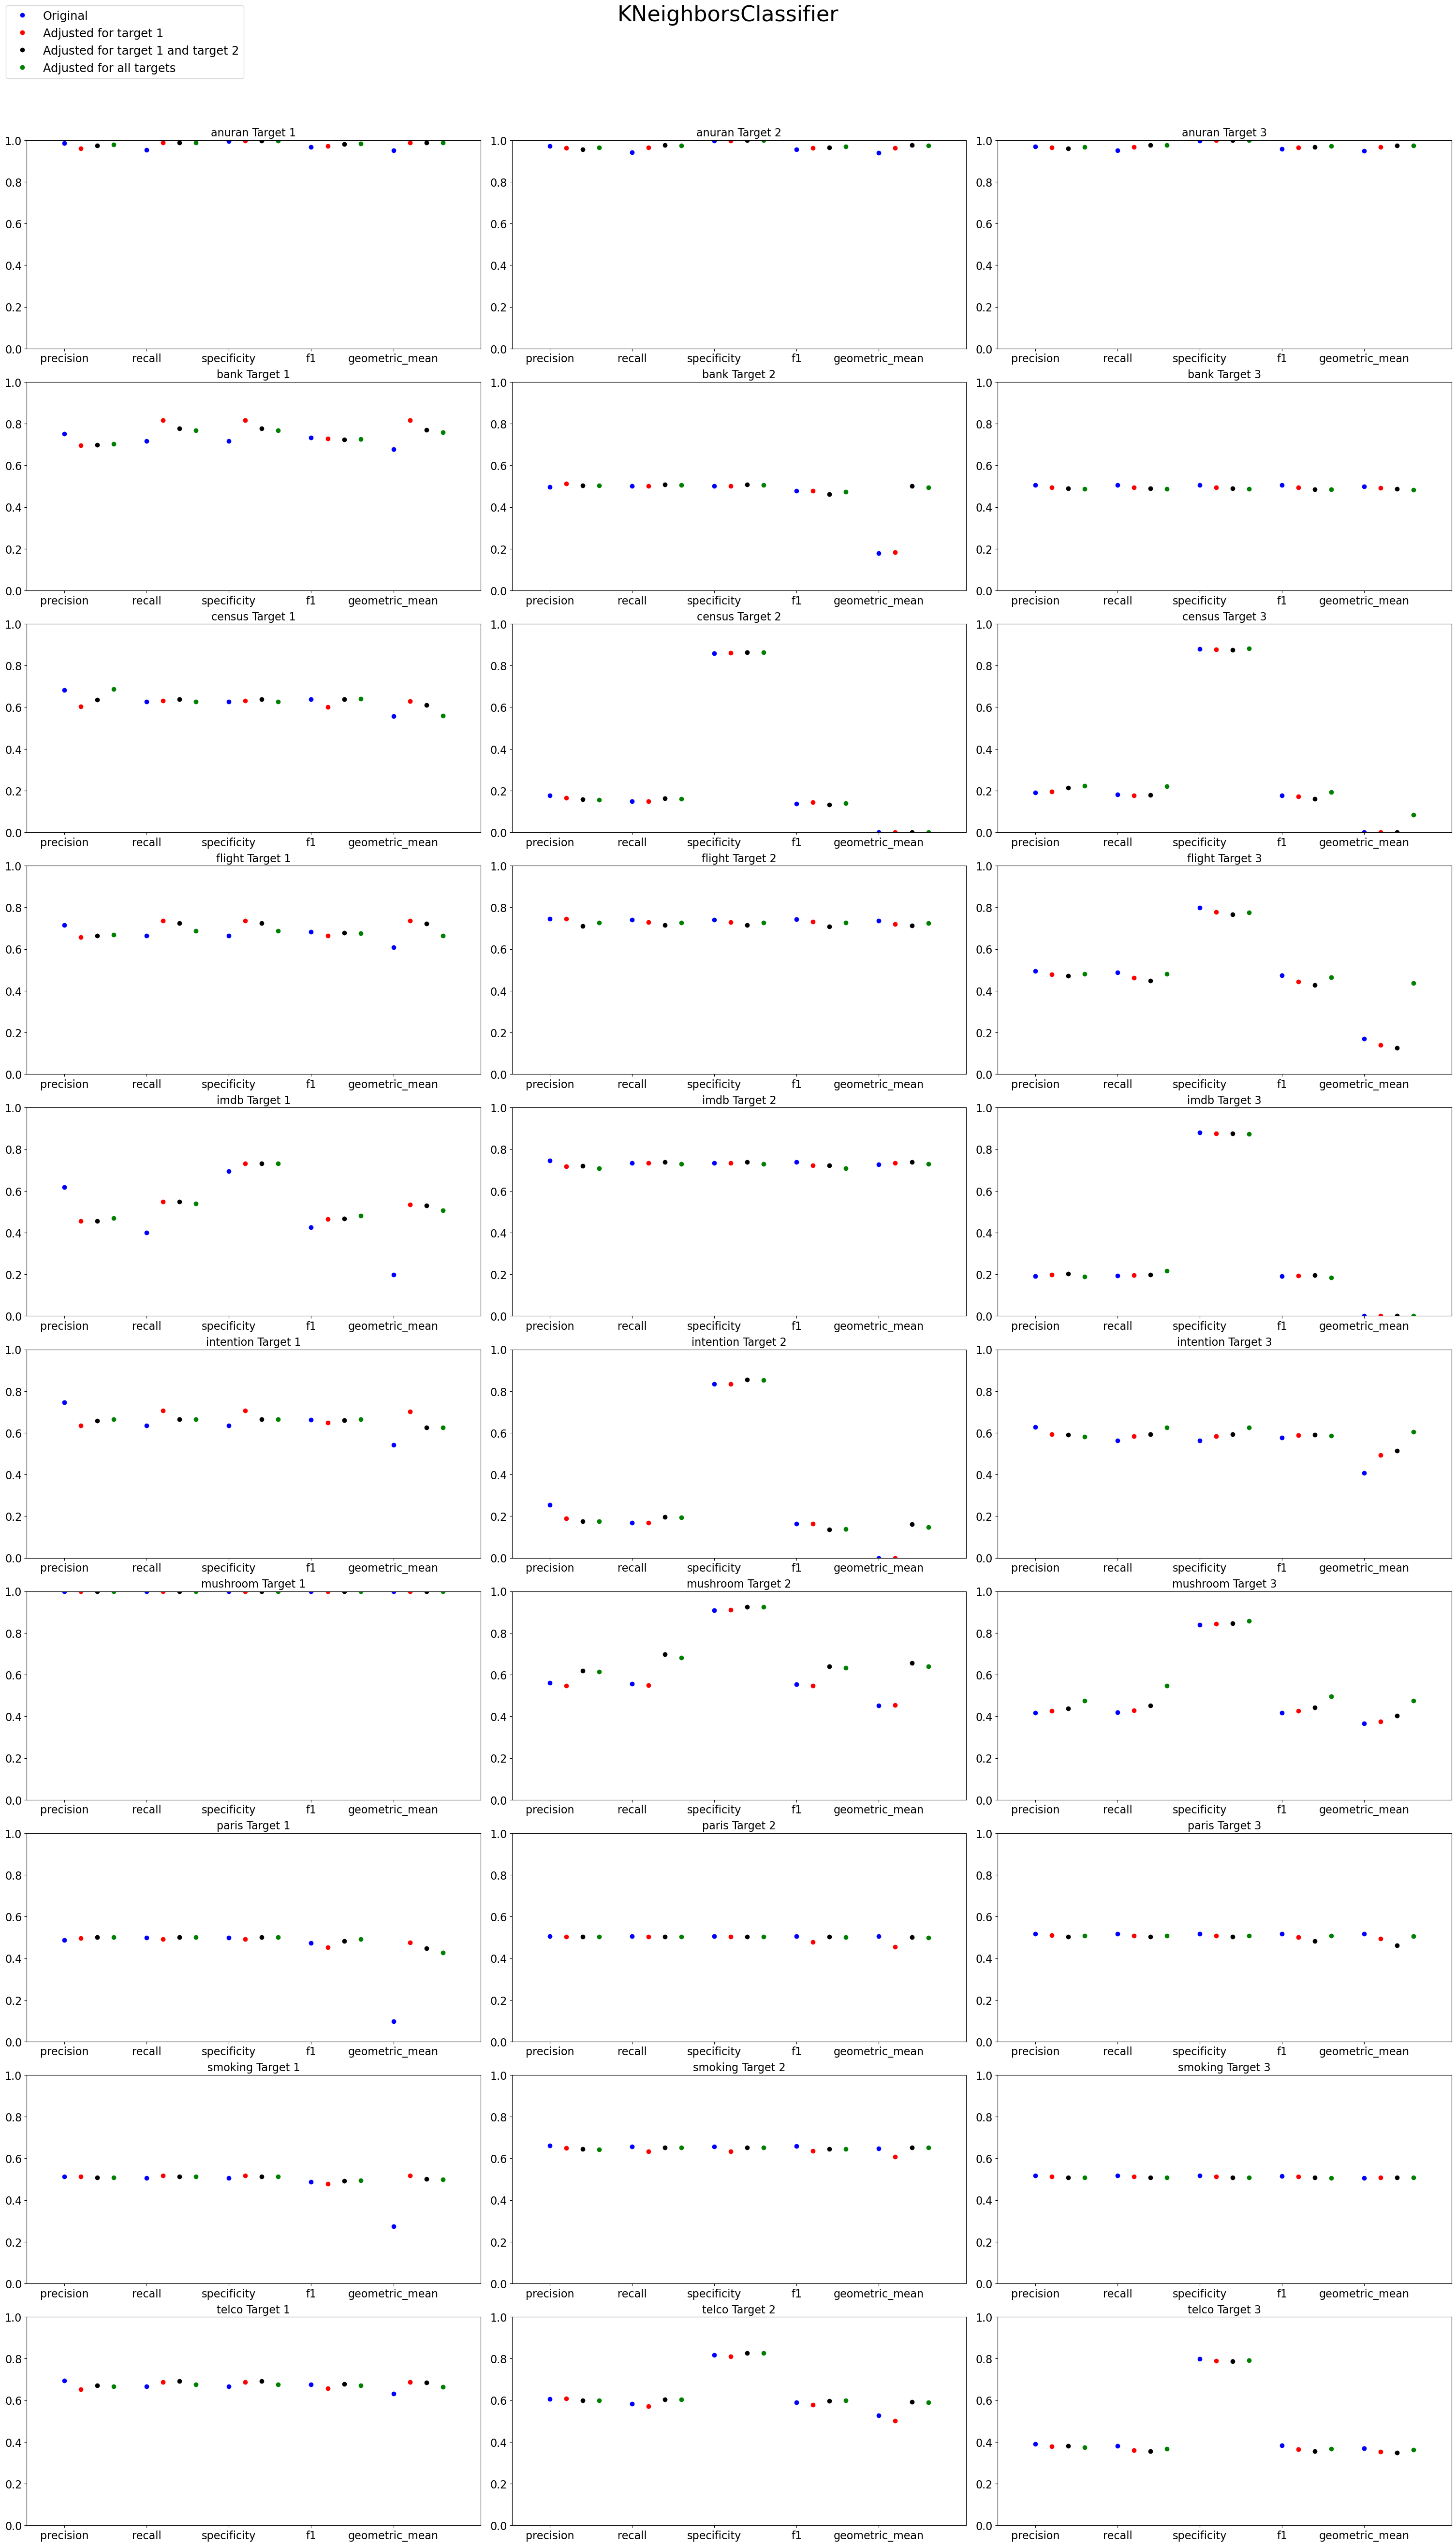

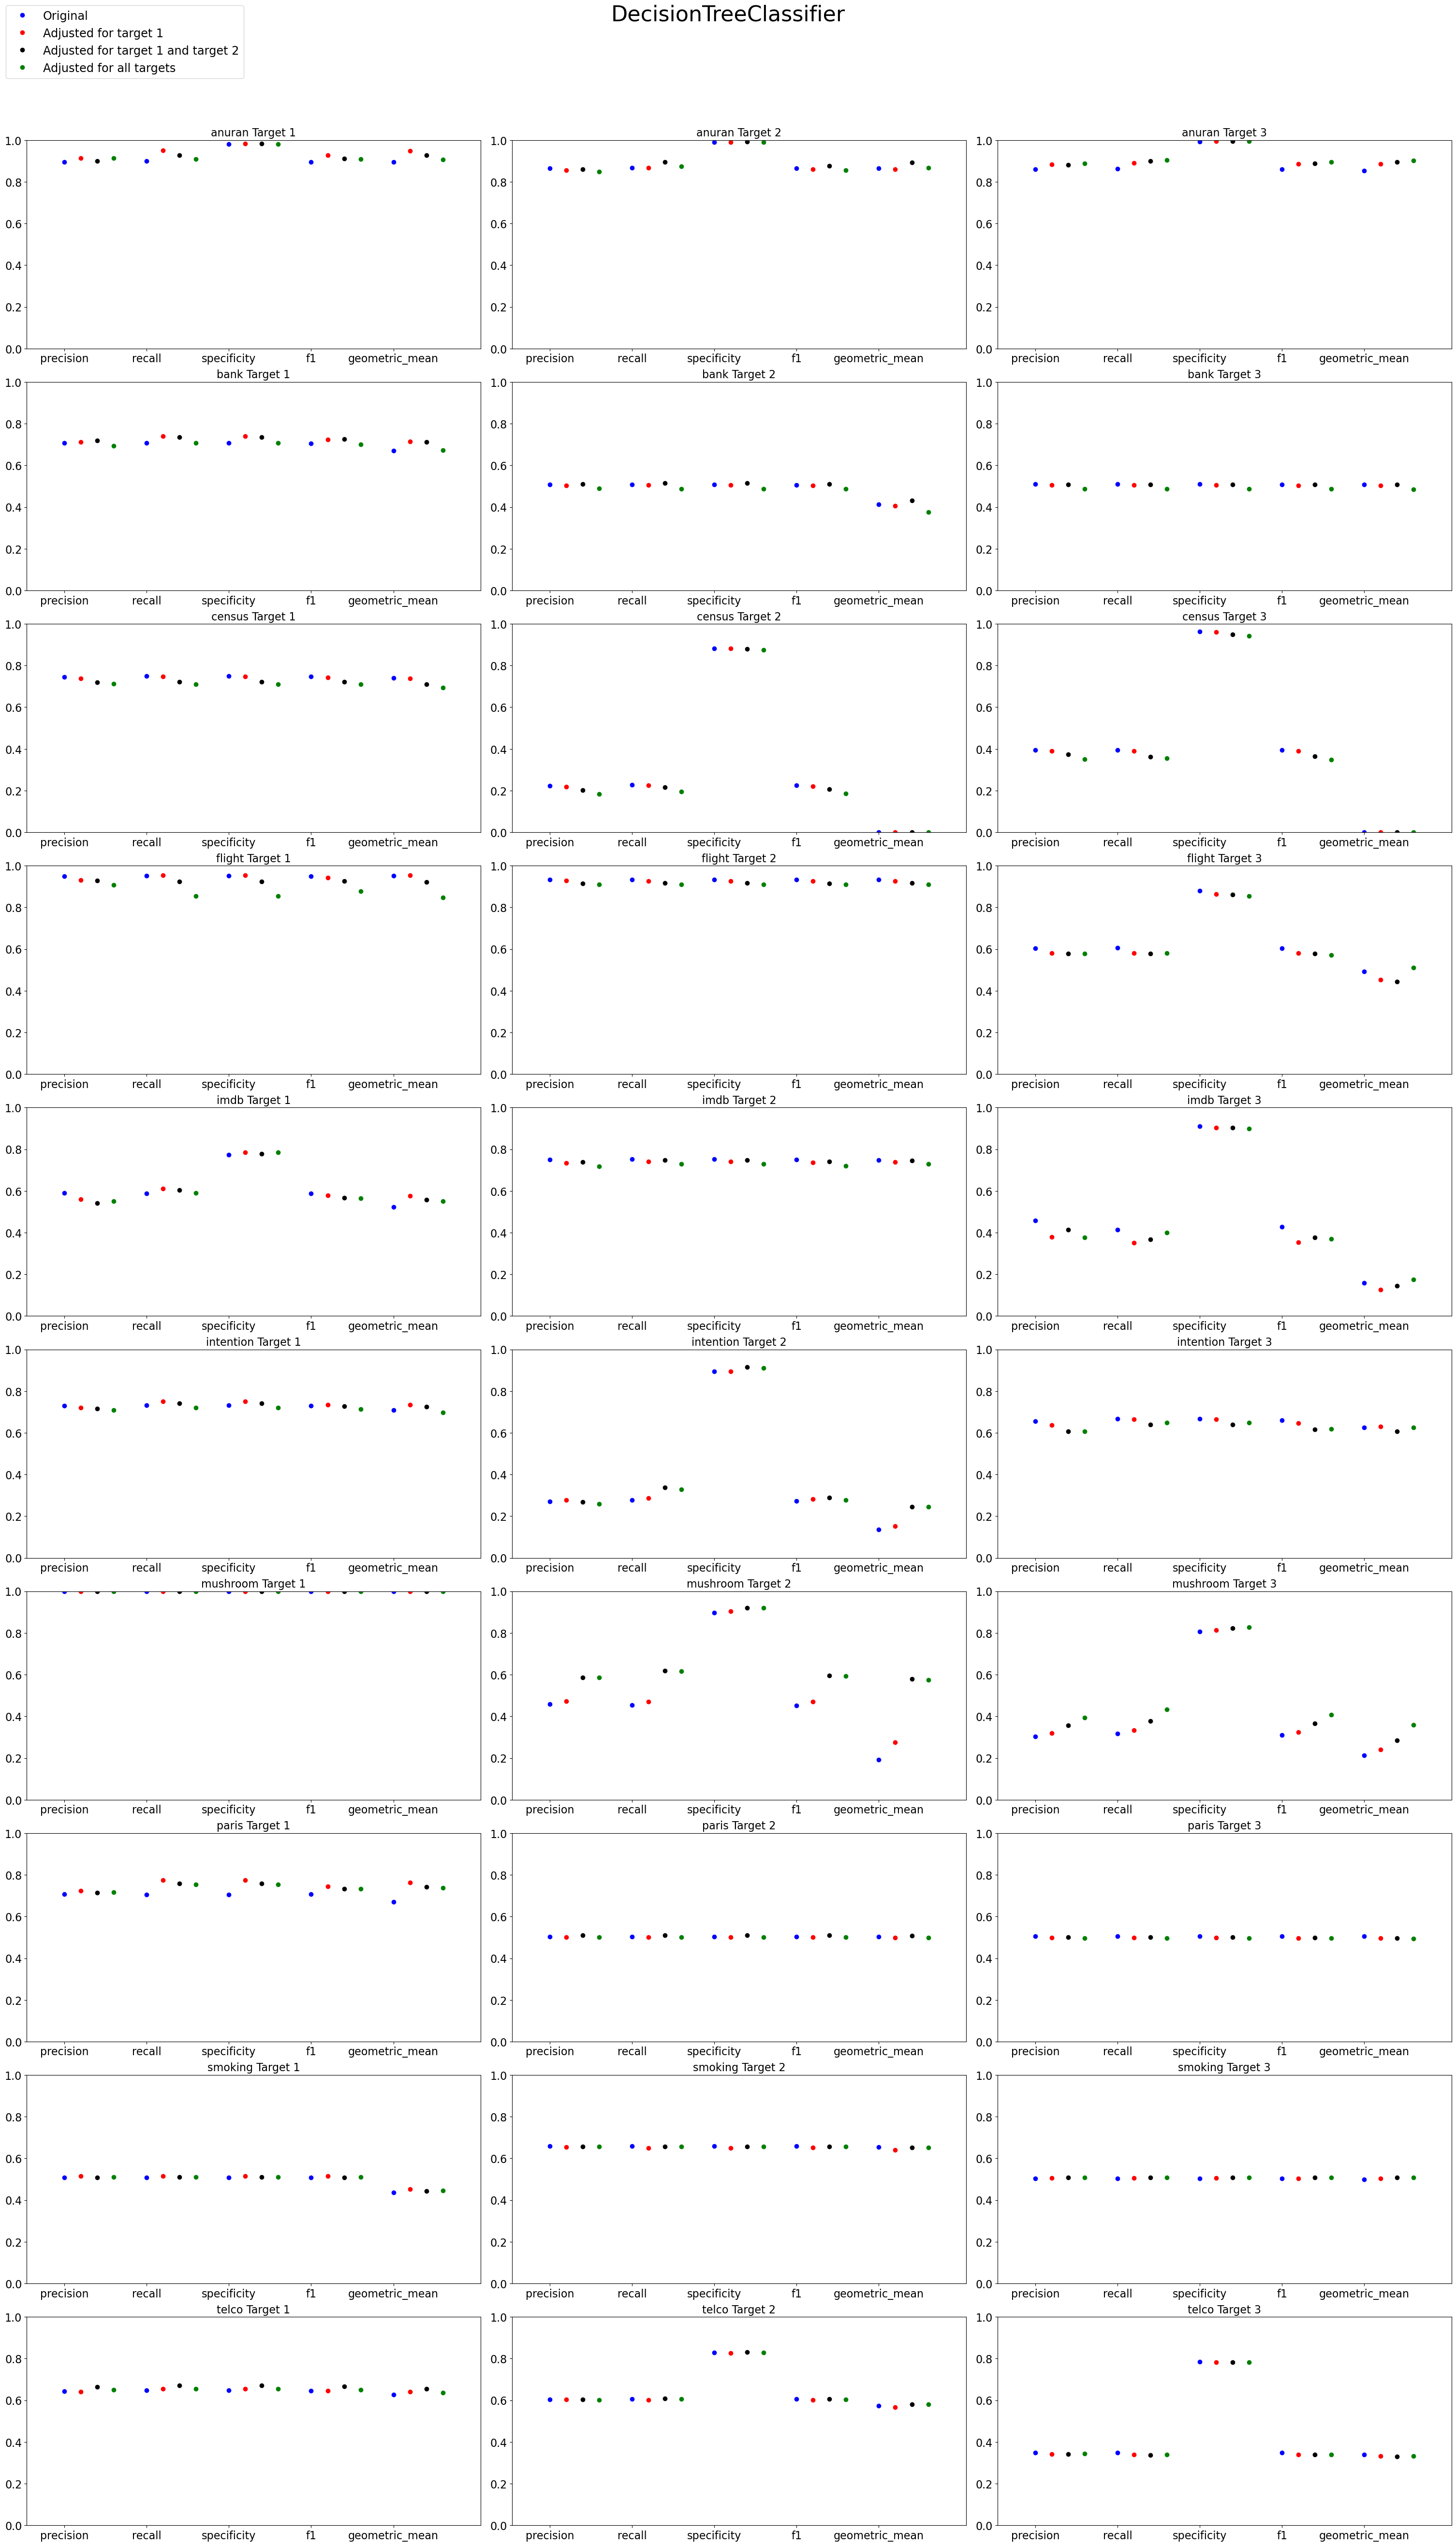

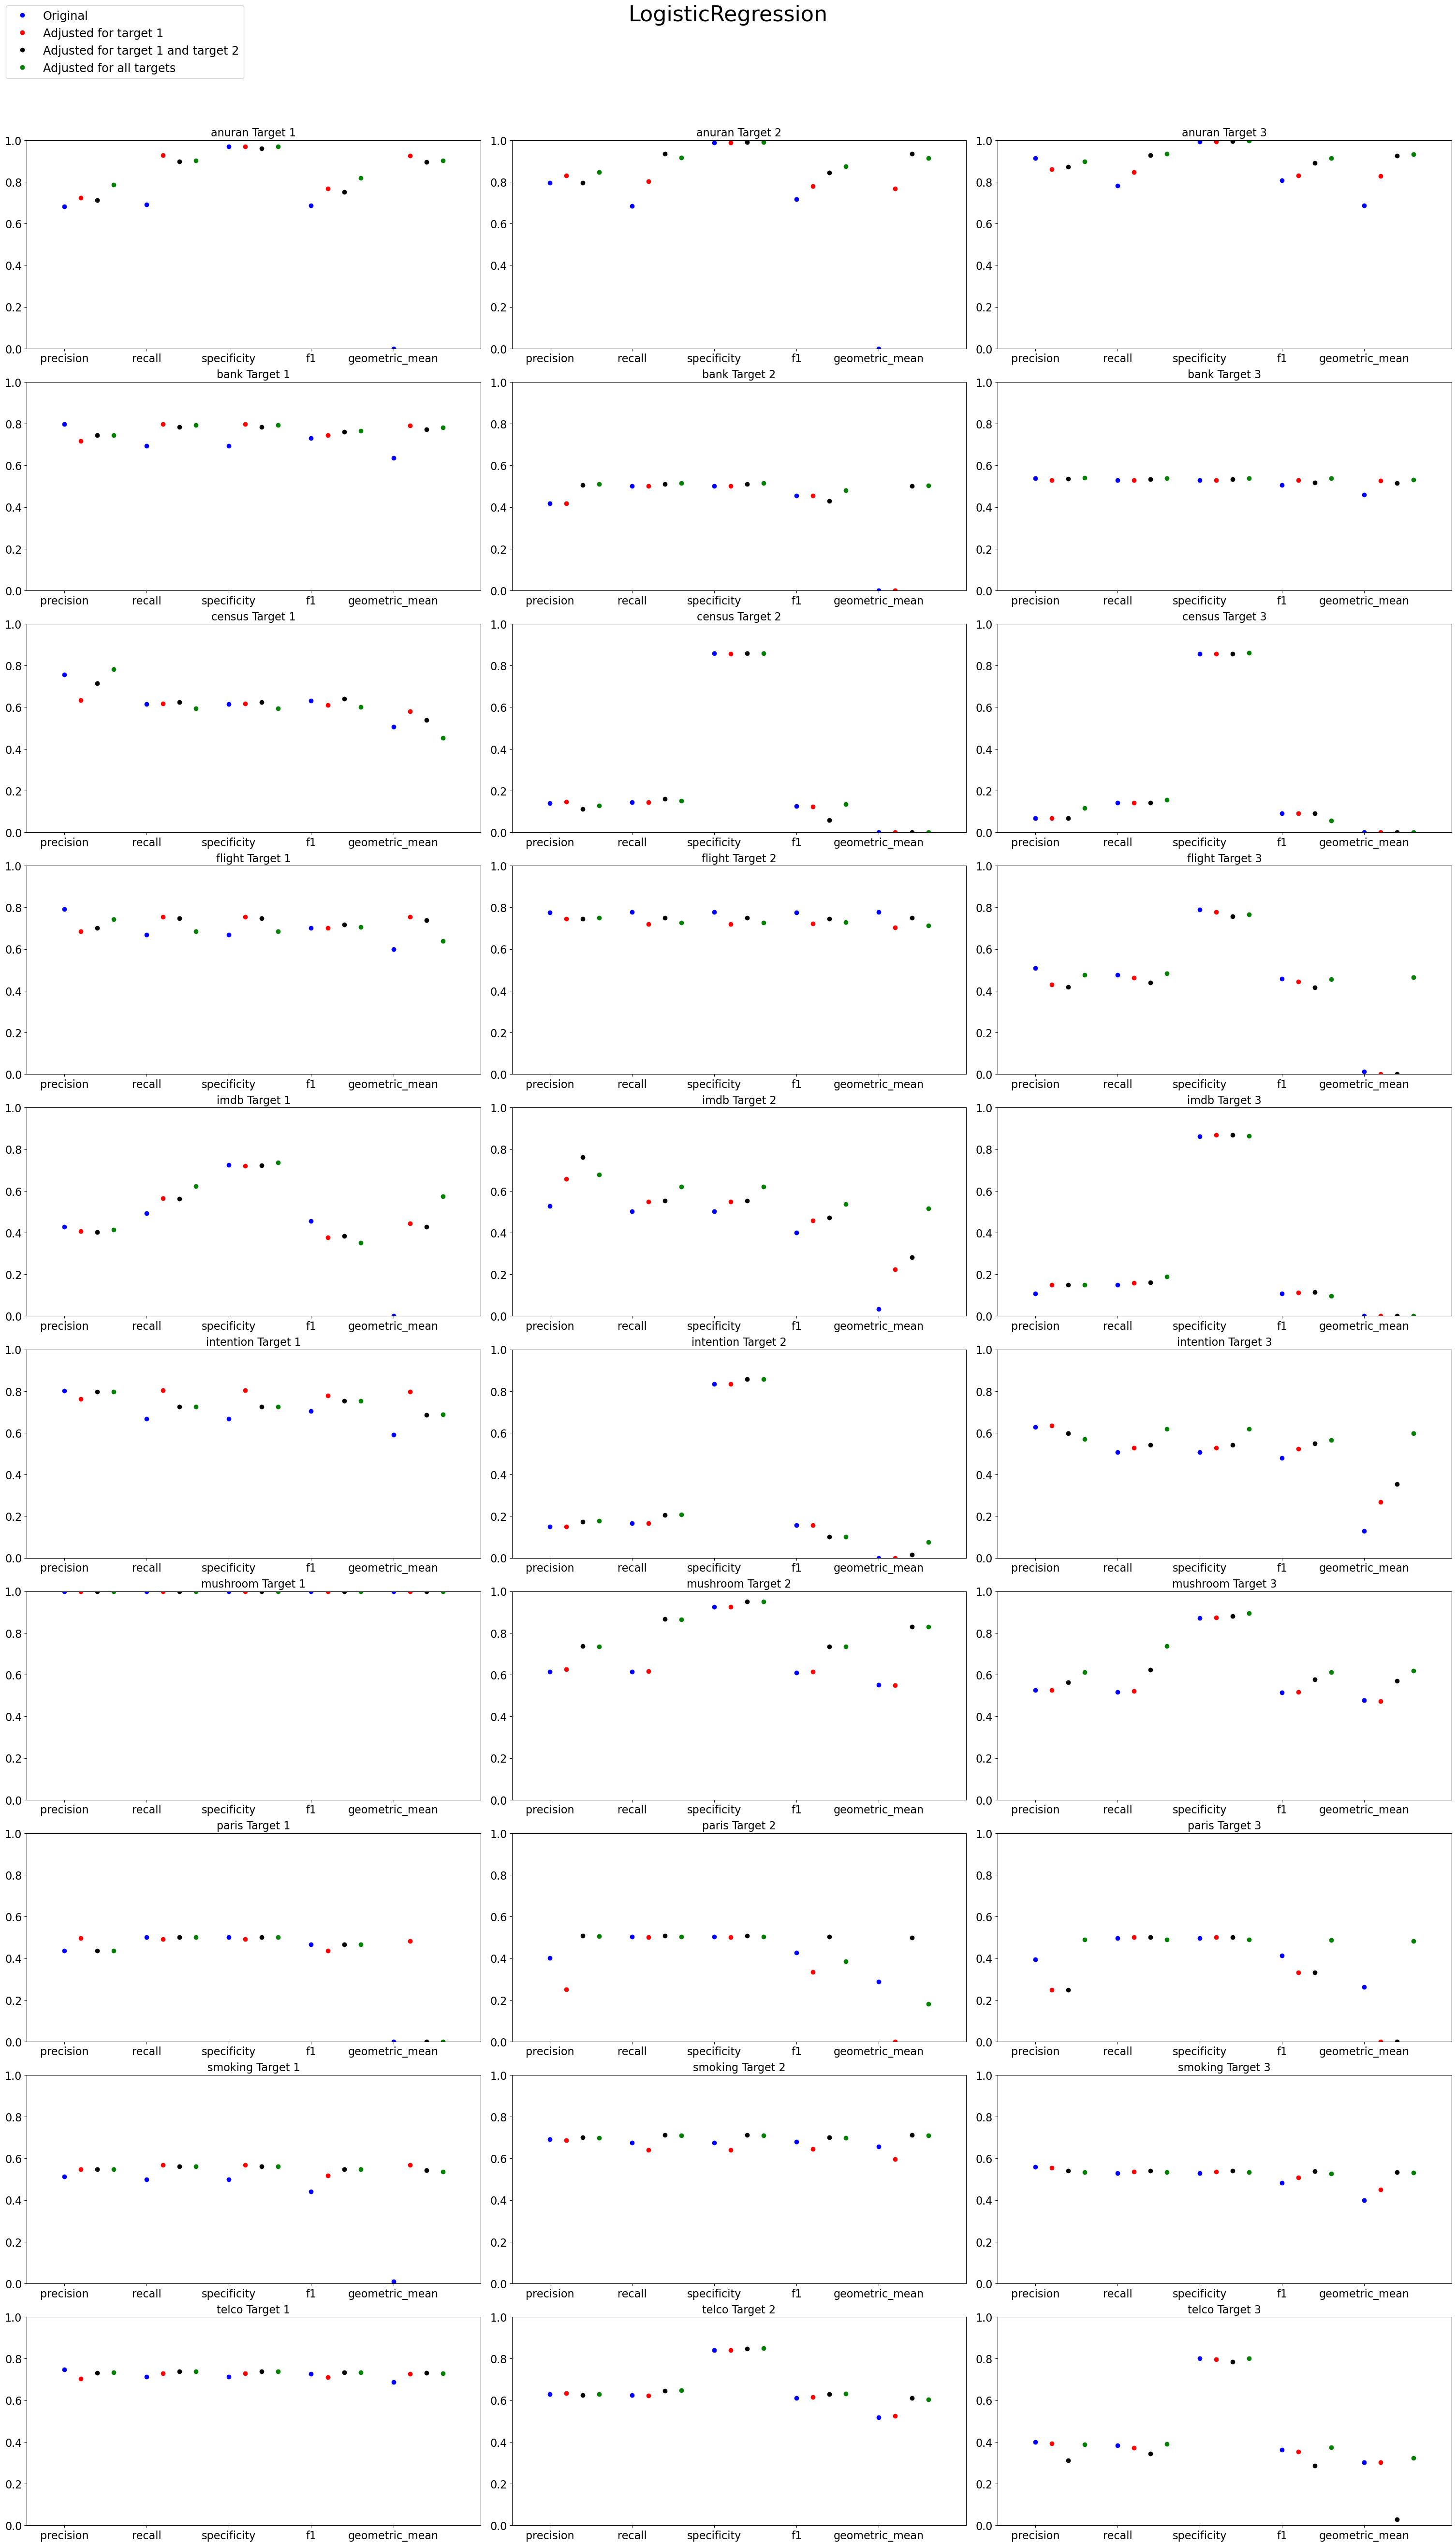

In [82]:
from matplotlib.transforms import Affine2D

plt.figure(figsize=(25, 25), dpi=100)

learners = list(aggregateMetrics.keys())
for learner in learners:
  metrics = ['precision', 'recall', 'specificity', 'f1', 'geometric_mean']
  
  fig, axs = plt.subplots(10, 3, constrained_layout=False)
  fig.suptitle(learner, fontsize=32, y=1.05)
  fig.set_figwidth(30)
  fig.set_figheight(50)

  loc = ticker.MultipleLocator(base=2.5) # this locator puts ticks at regular intervals

  # Iterate through the 3 targets
  for k in range(0, 10):
    for i in range(3):
      # print(allAggregatePerformances.keys())
      for j, AggregatePerformance in enumerate(allAggregatePerformances):
        # print(curr[0][learner].iloc[3])
        curr = allAggregatePerformances[AggregatePerformance]
        currentSet = curr[0][learner].iloc[k*3]['dataset']
        performance = curr[0][learner].iloc[k*3+i].values
        performanceStandardDev = curr[1][learner].iloc[k*3+i].values
        transformation = Affine2D().translate(0.2*j, 0.0) + axs[k][i].transData
        axs[k][i].set(xmargin= 0.1, ylim=(0, 1))
        # axs[i].errorbar(metrics, performance, fmt=curr[2],yerr=performanceStandardDev, linewidth=1, capsize=6, transform=transformation, label=AggregatePerformance)
        # print(curr[2])
        axs[k][i].errorbar(metrics, performance[2:], fmt=curr[2], linewidth=1, capsize=6, transform=transformation, label=AggregatePerformance)

      axs[k][i].set_title(f'{currentSet} Target {i+1}',fontsize=16)
      axs[k][i].tick_params(axis='both', which='major', labelsize=16)
  handles, labels = axs[0][0].get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper left', fontsize='xx-large')
plt.show()

In [83]:
cols = ['dataset', 't1', 't2', 't3']
df = pd.DataFrame(columns=cols)
for classifier in CLASSIFIERS:
  for dataset in DATA_KEYS:
    # for 
    orderedcomplexity = finalComplexityDF[finalComplexityDF['dataset']==dataset].sort_values(by=['value'])['Target'].values
    # for target in orderedcomplexity:
    #   print(DATA_STRUCTURE[dataset][target])
    row = pd.DataFrame([ dataset, DATA_STRUCTURE[dataset]['target1'], DATA_STRUCTURE[dataset]['target2'], DATA_STRUCTURE[dataset]['target3']]).T
    row.columns = cols
    df = pd.concat((df, row), axis=0, ignore_index=True)
    

In [84]:
targetComplexities = list(finalComplexityDF.loc[finalComplexityDF['dataset']==dataset]['value'].values)

targetComplexities


[0.1945291805354977, 0.2700348297512491, 0.3633260481747202]

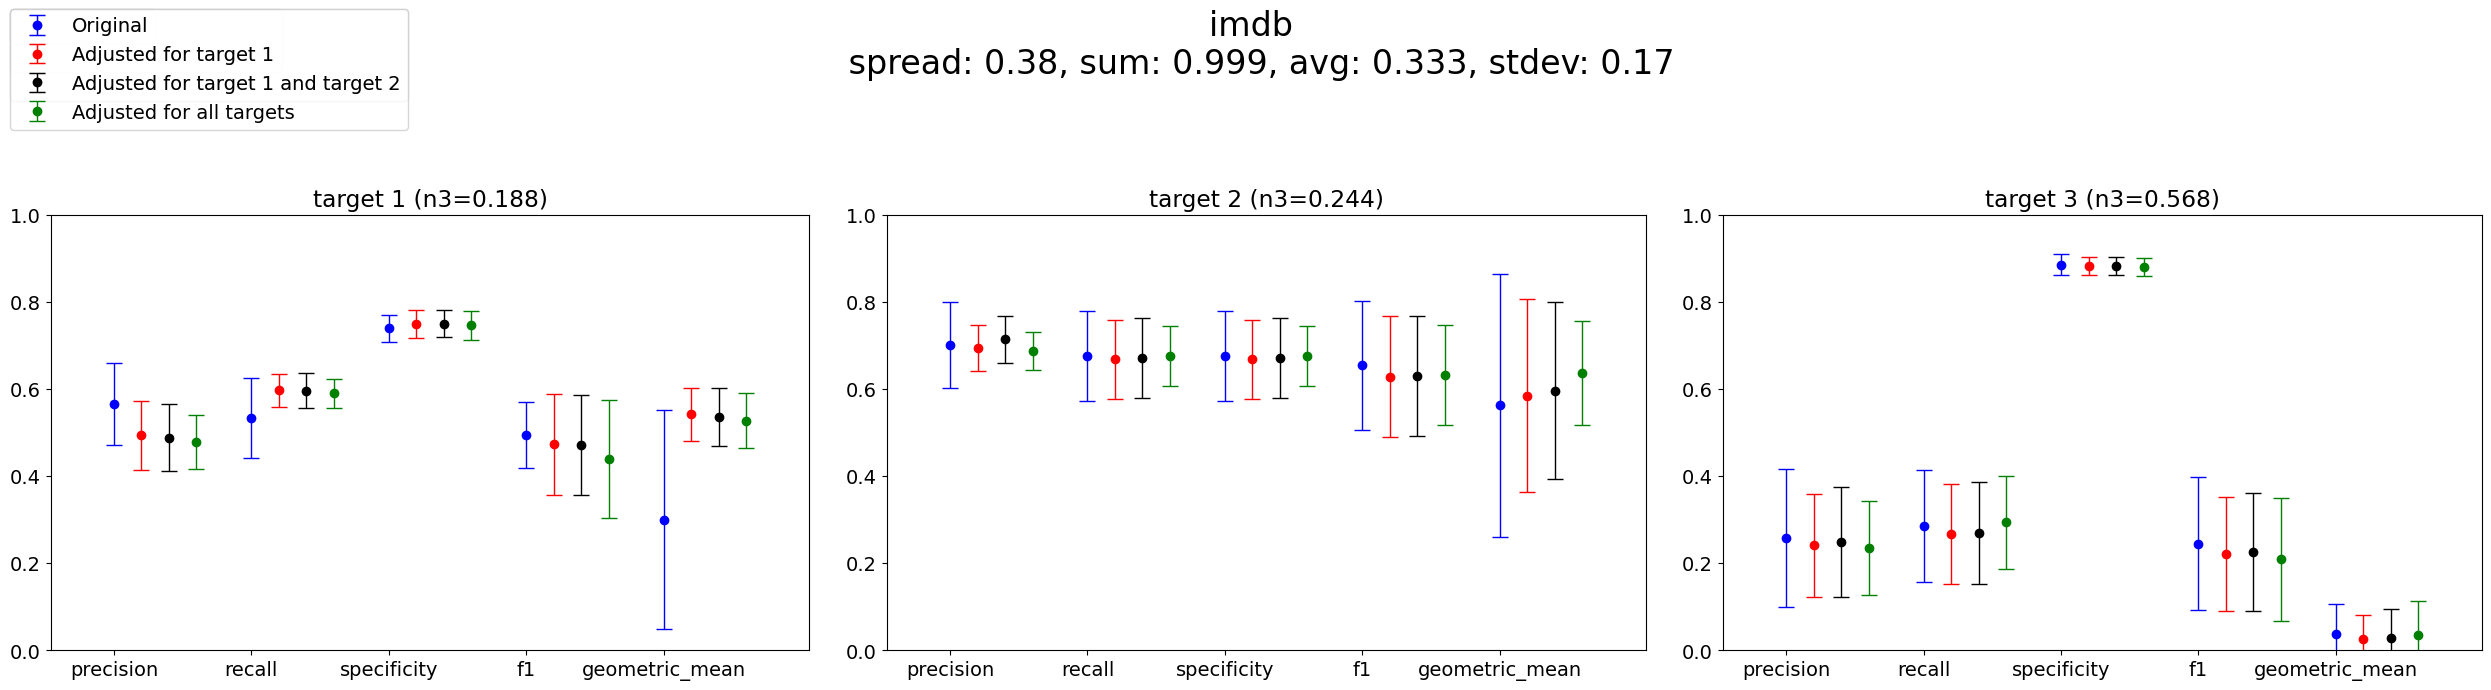

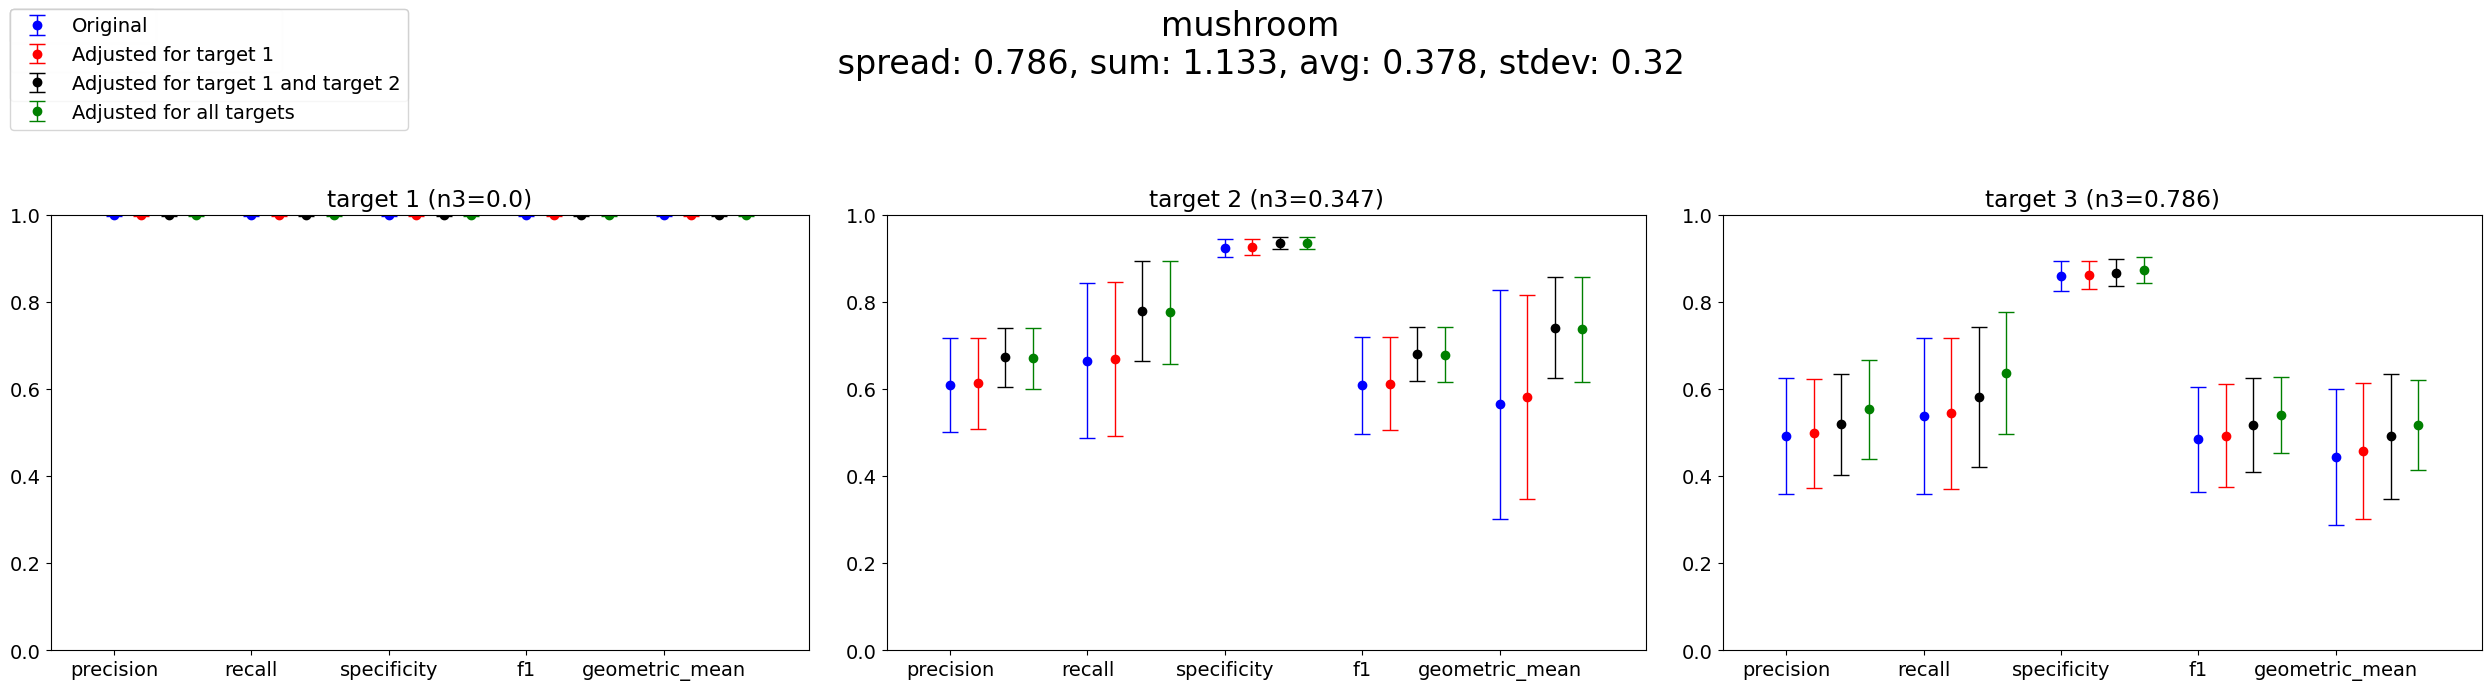

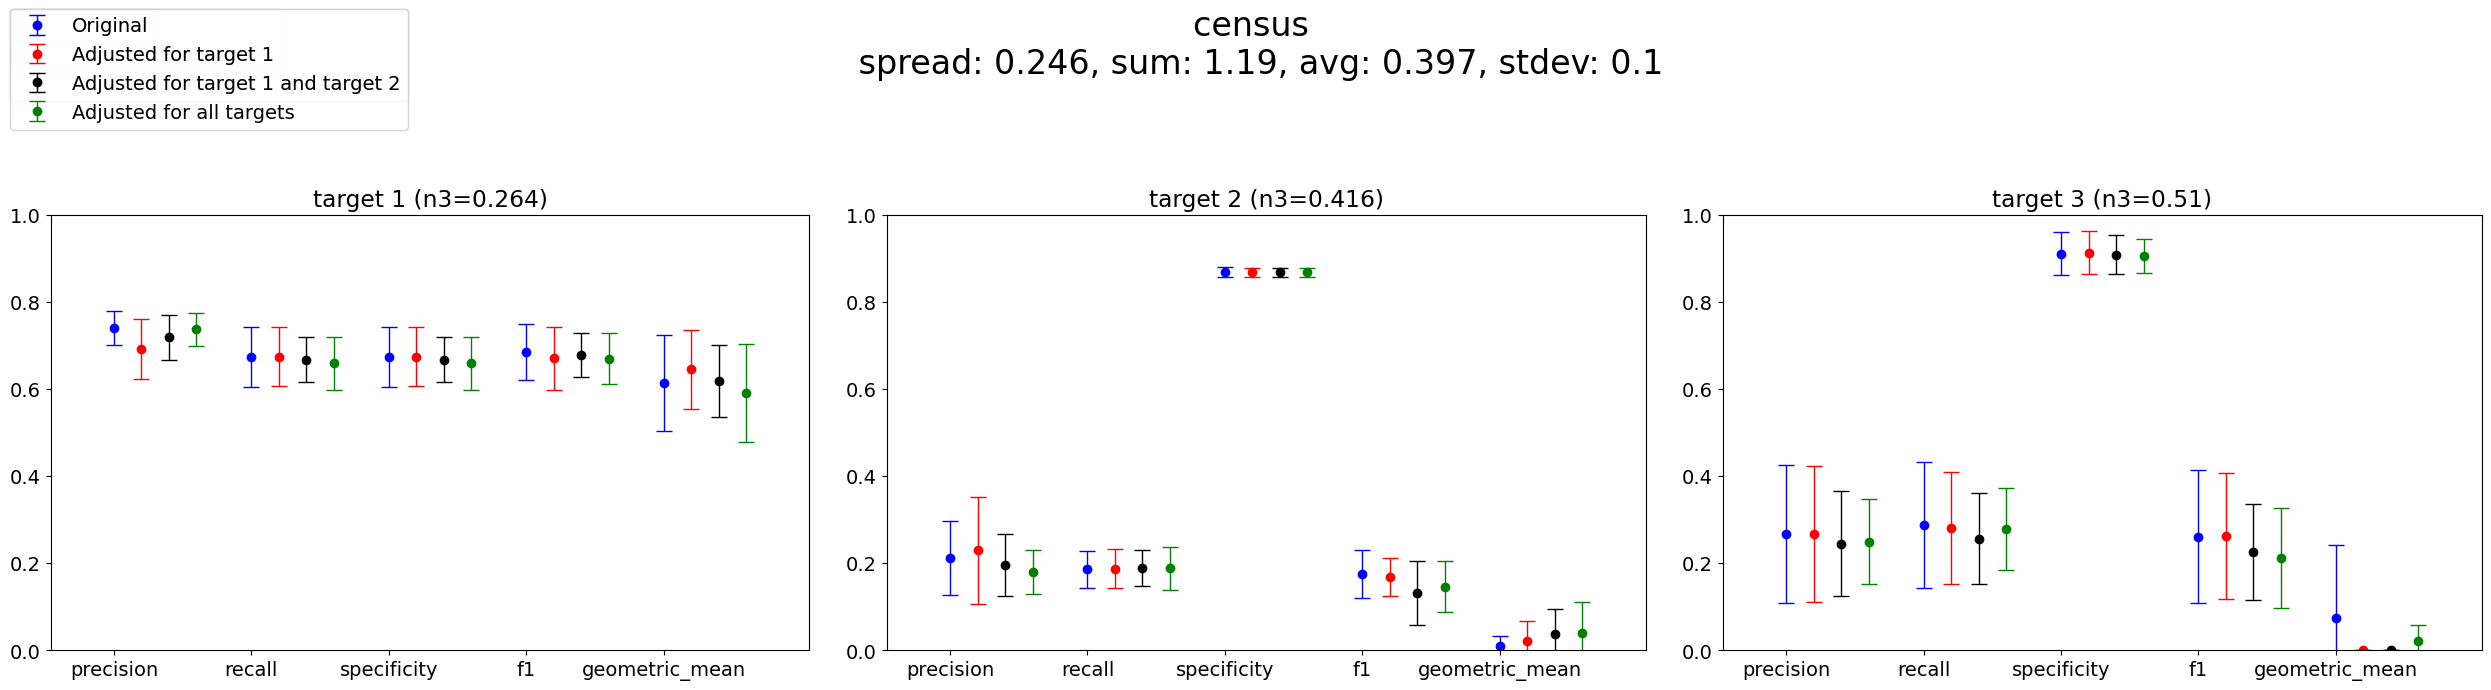

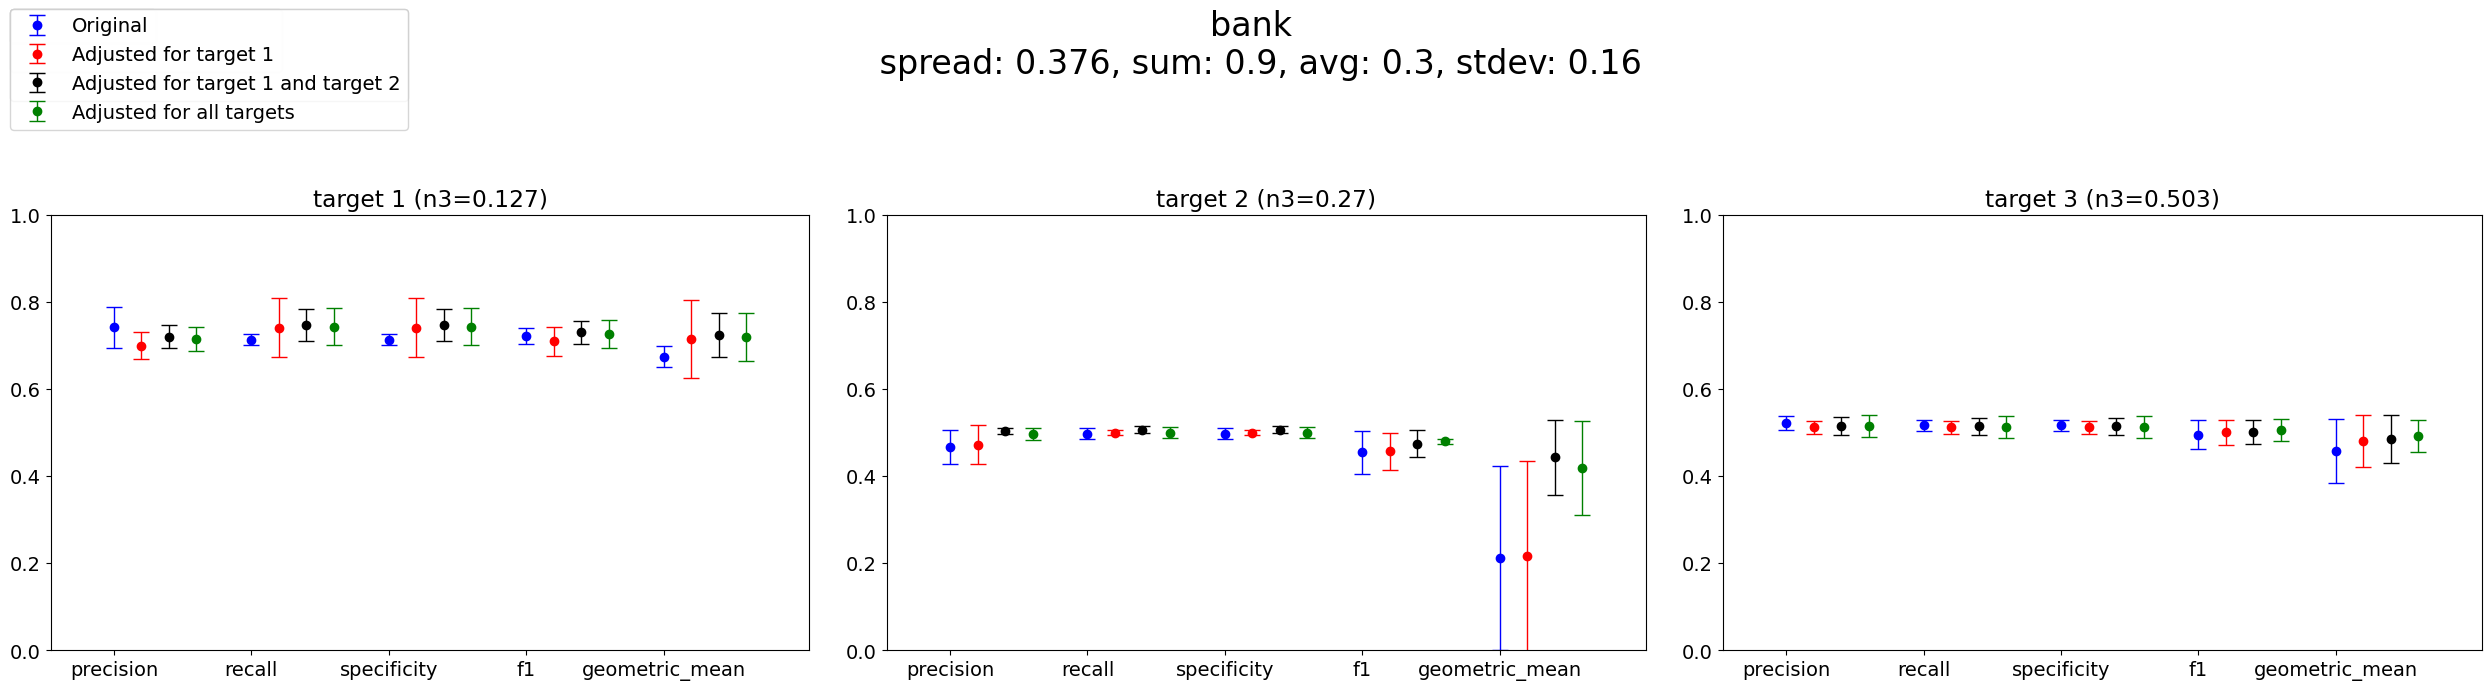

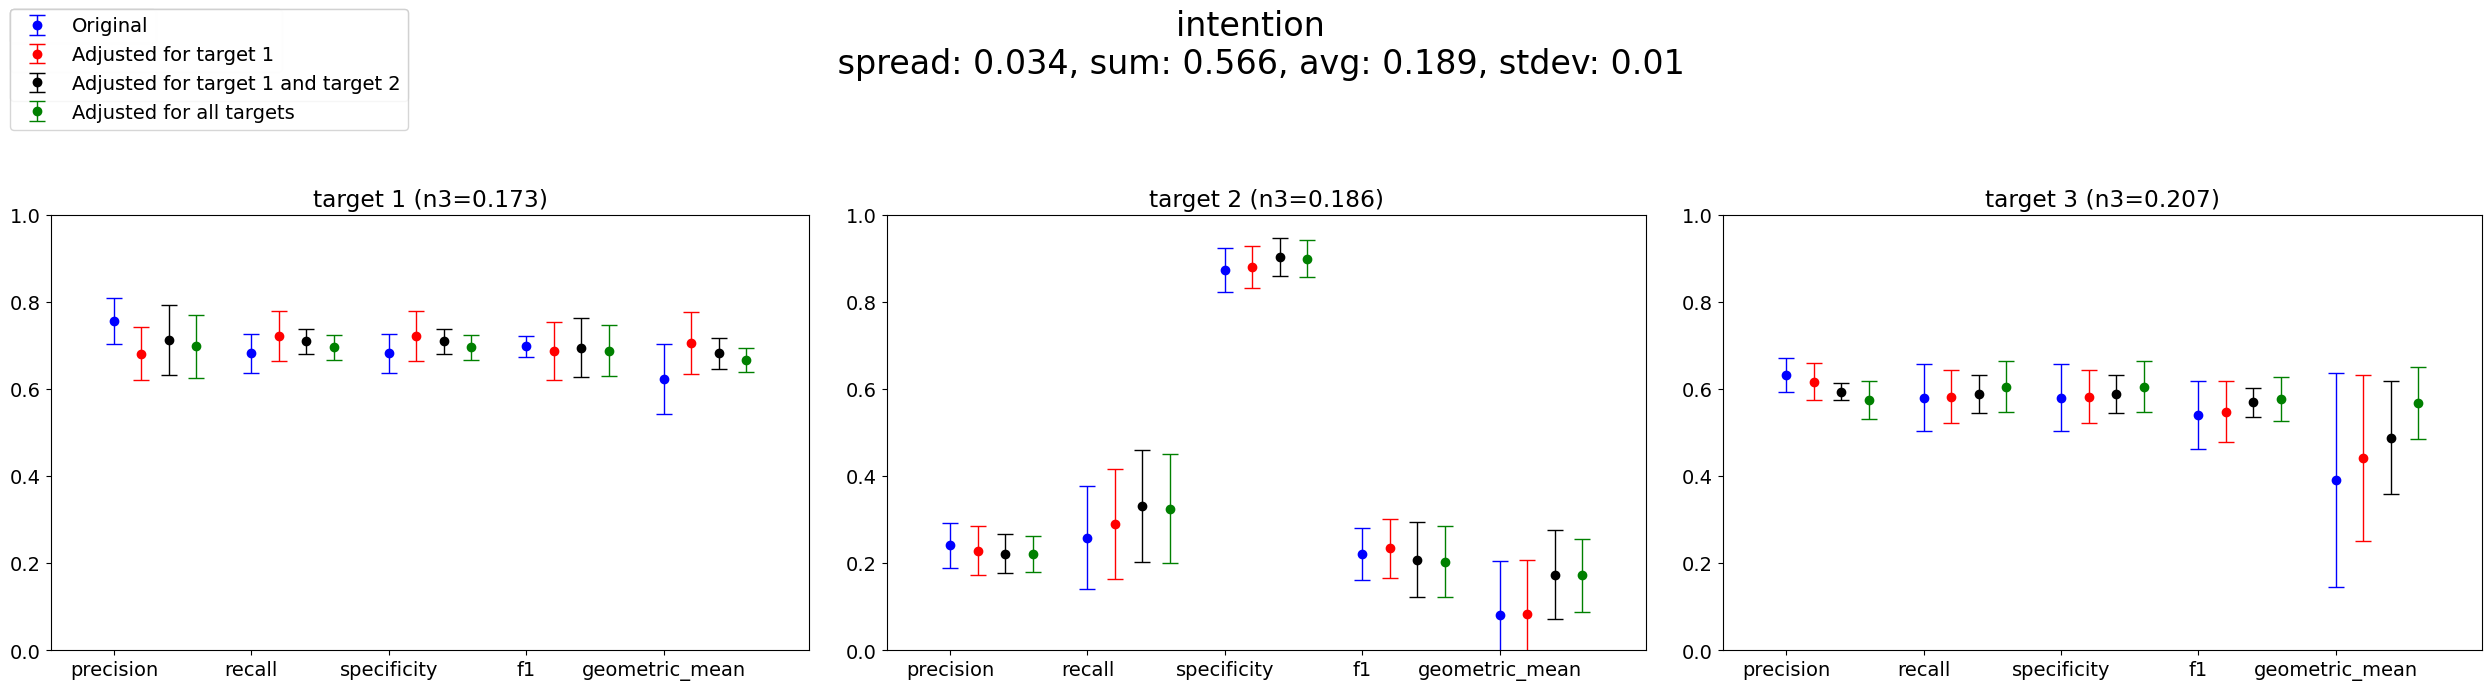

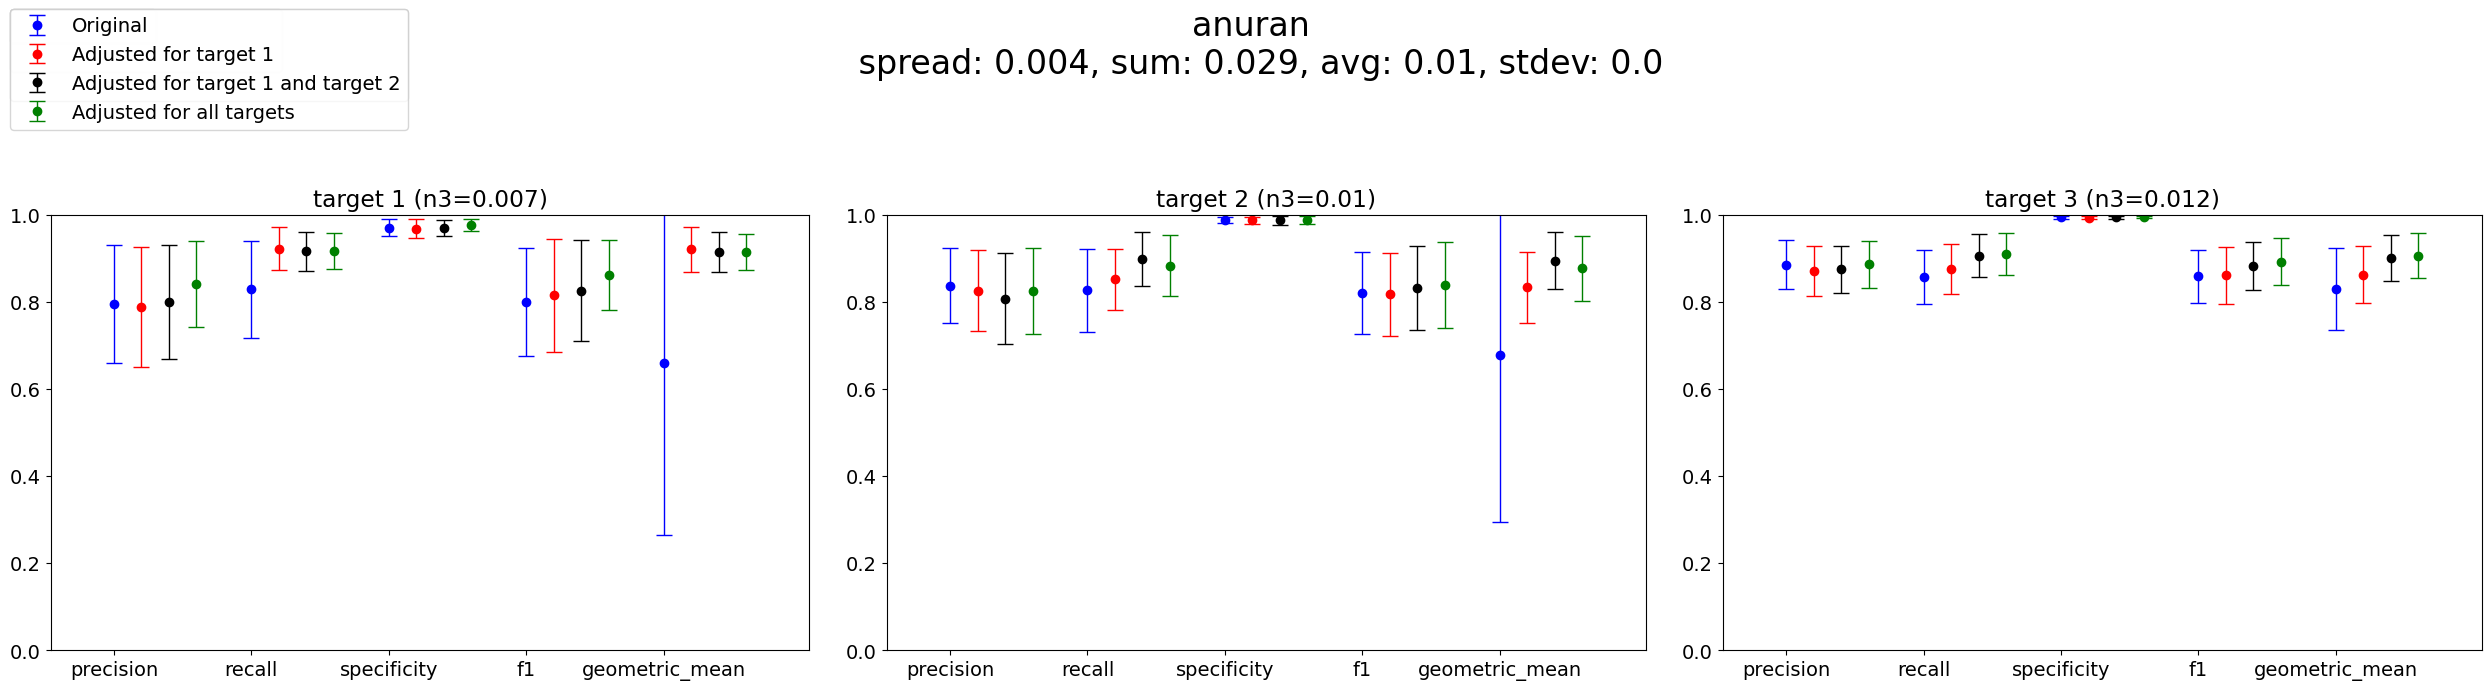

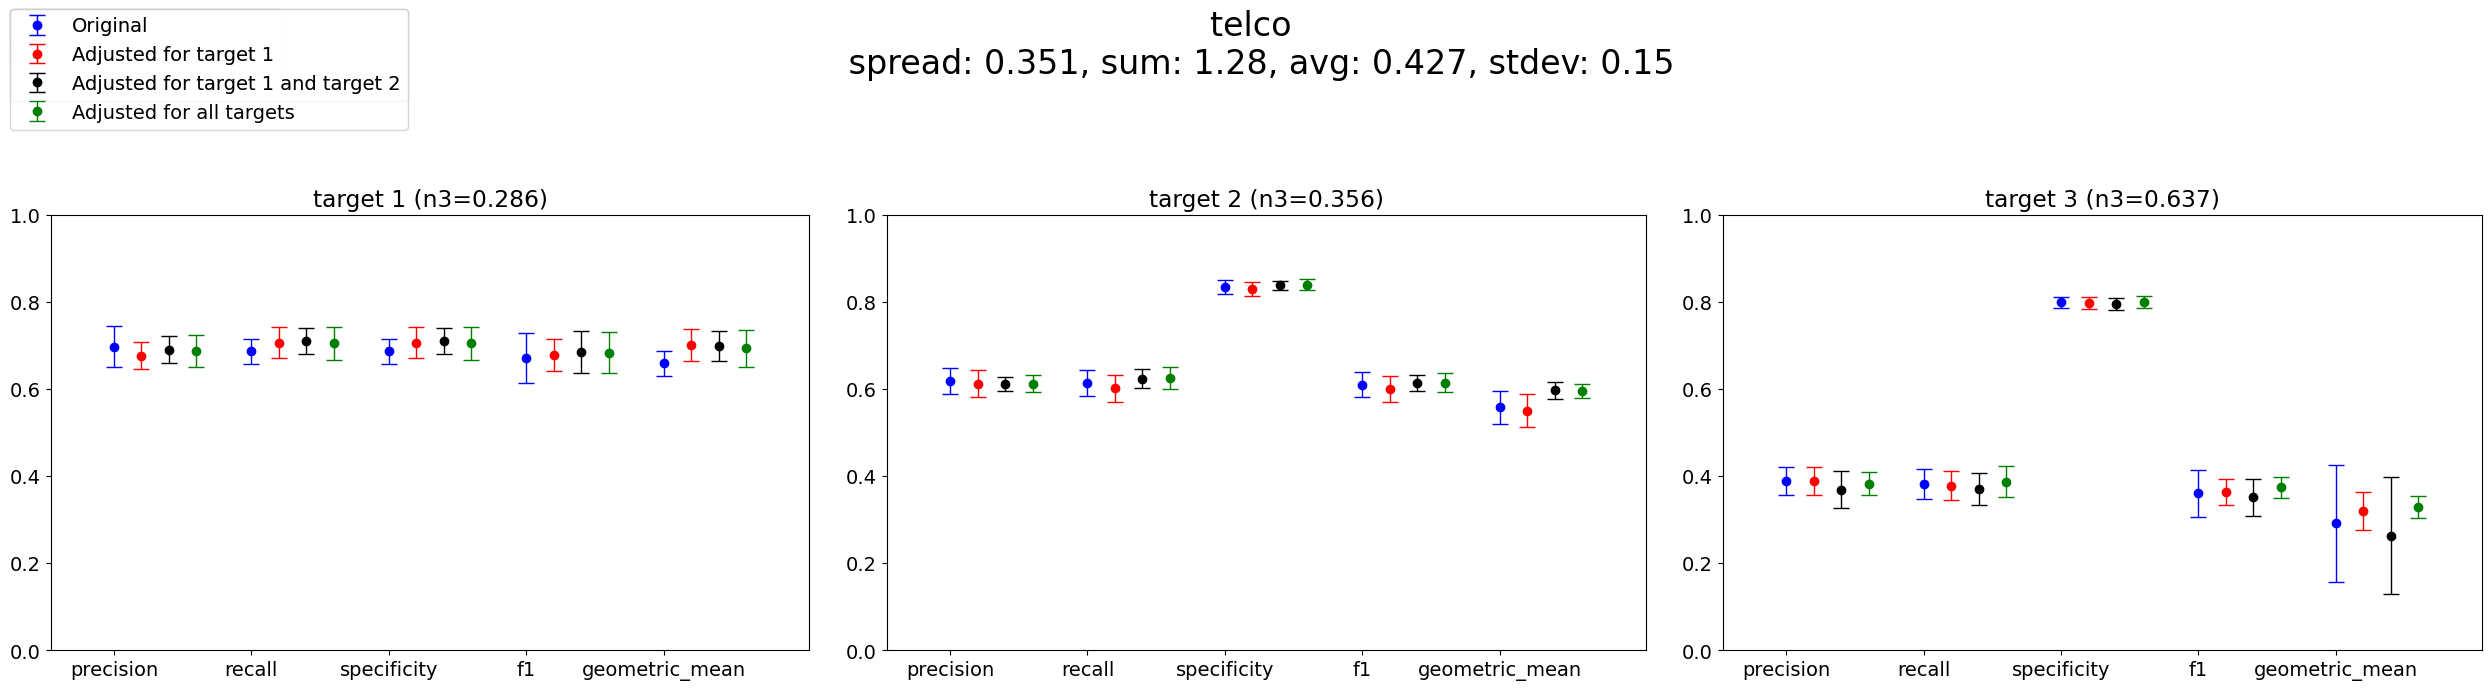

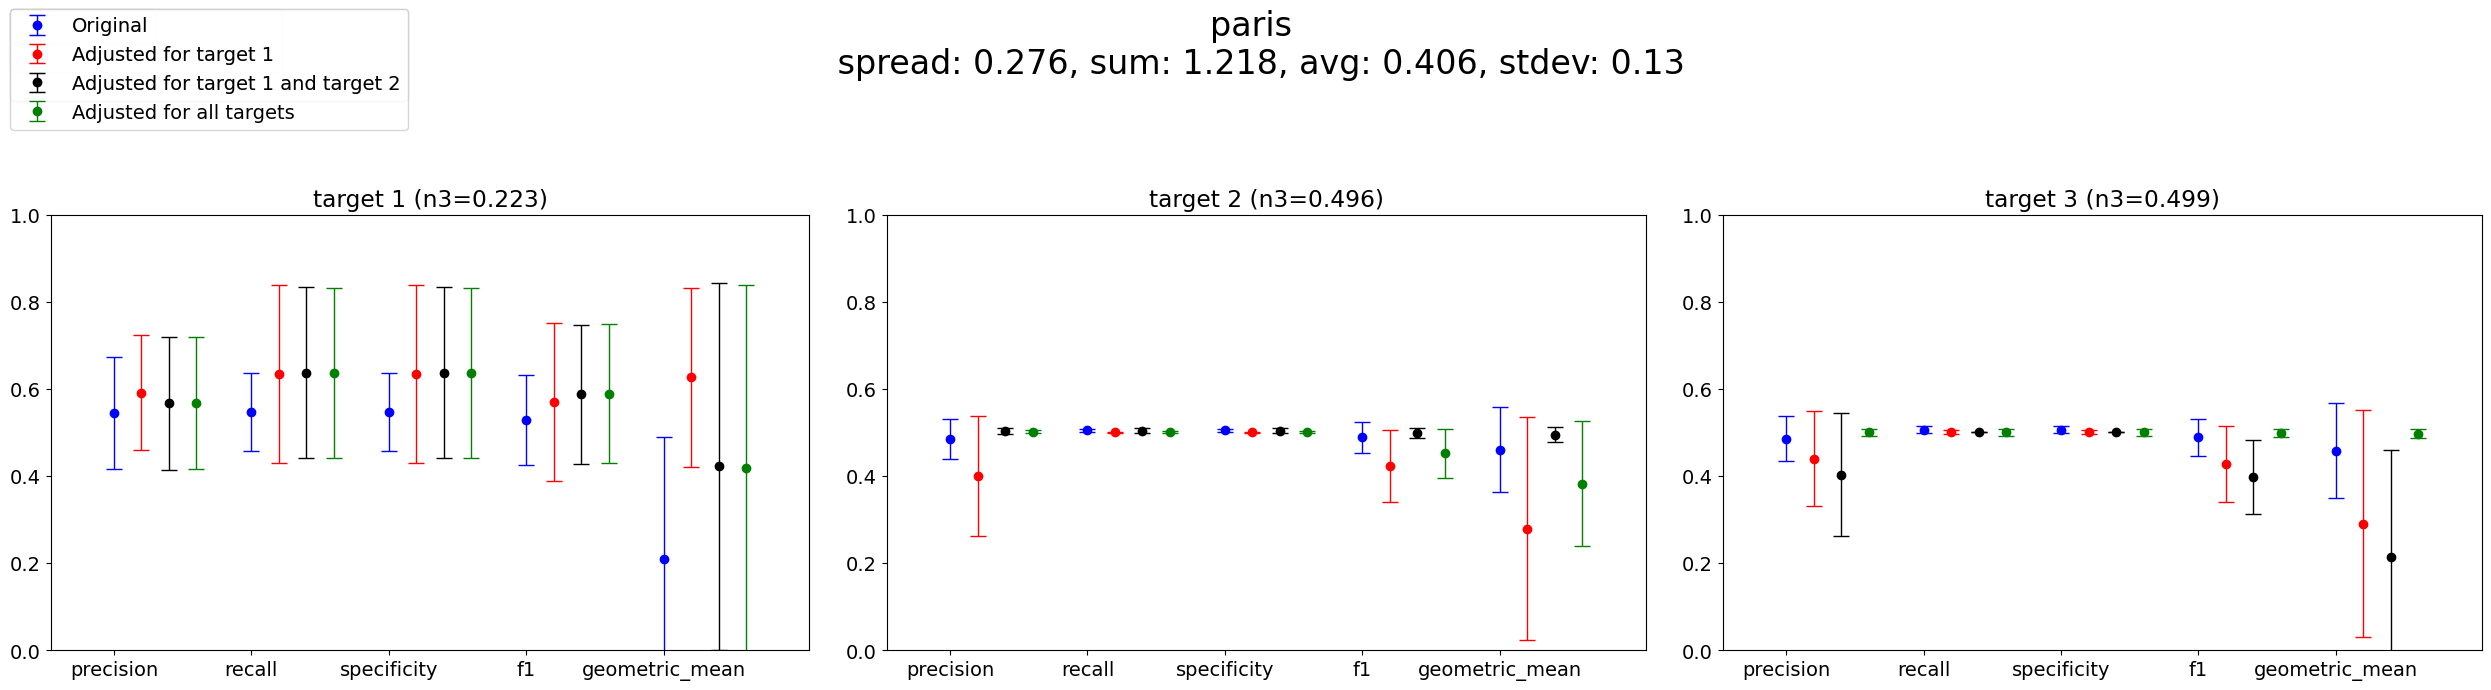

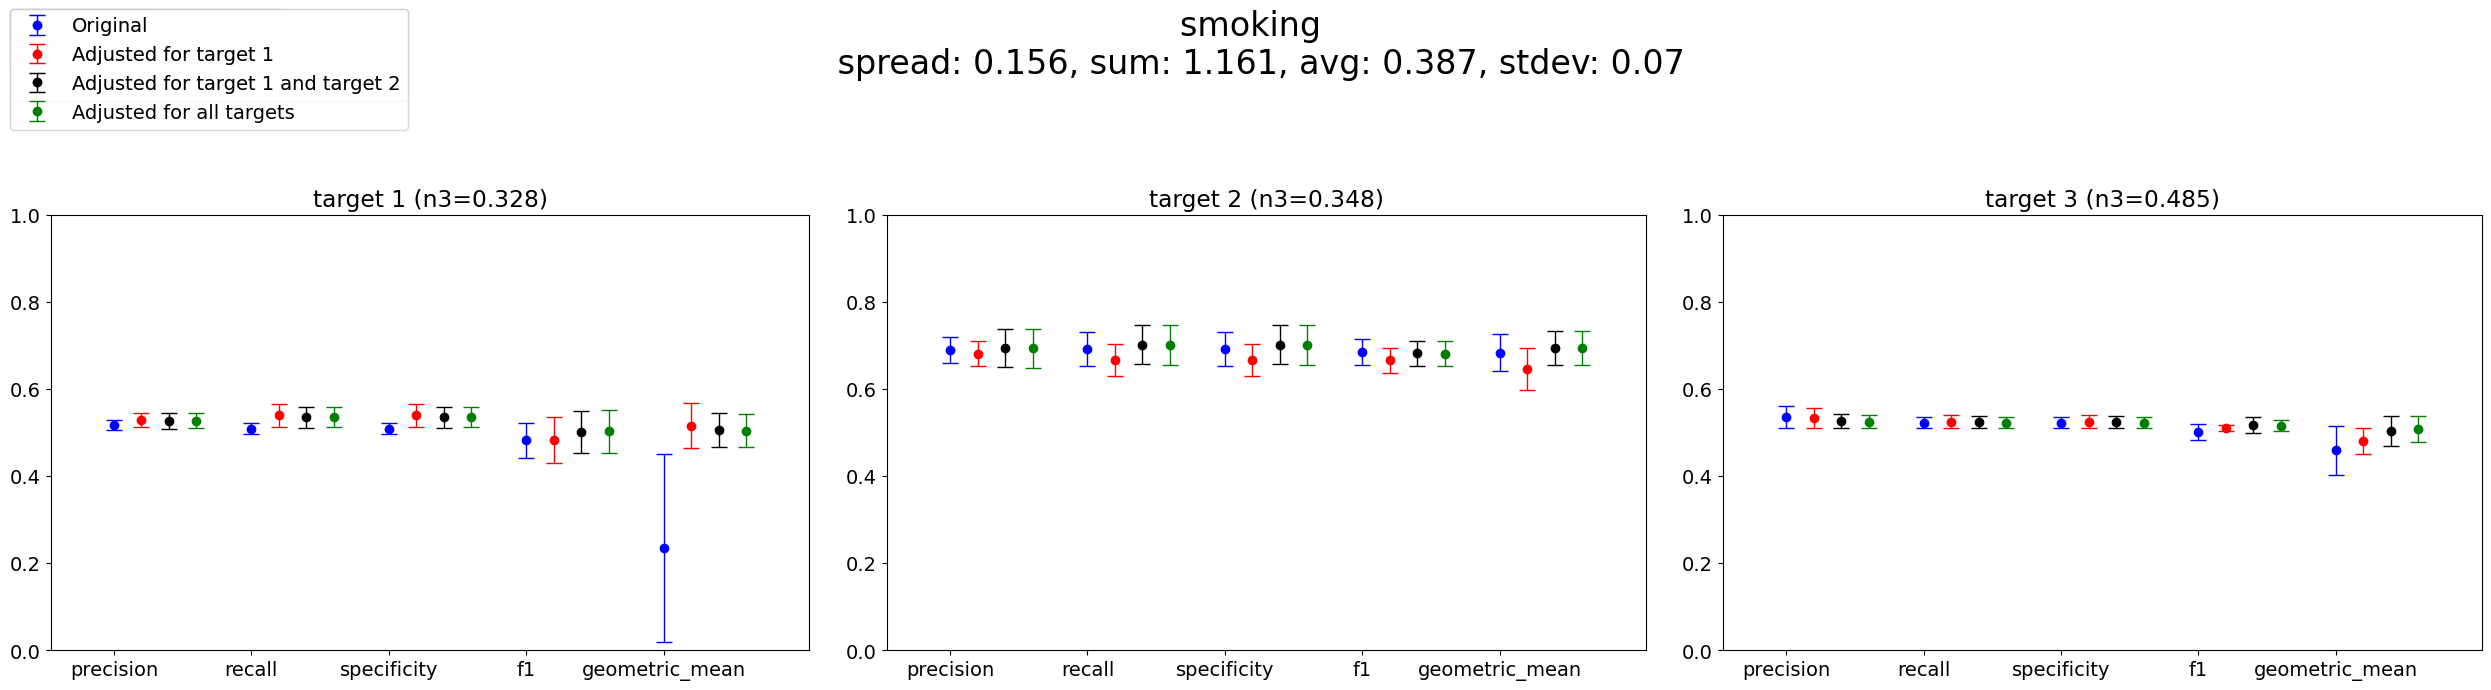

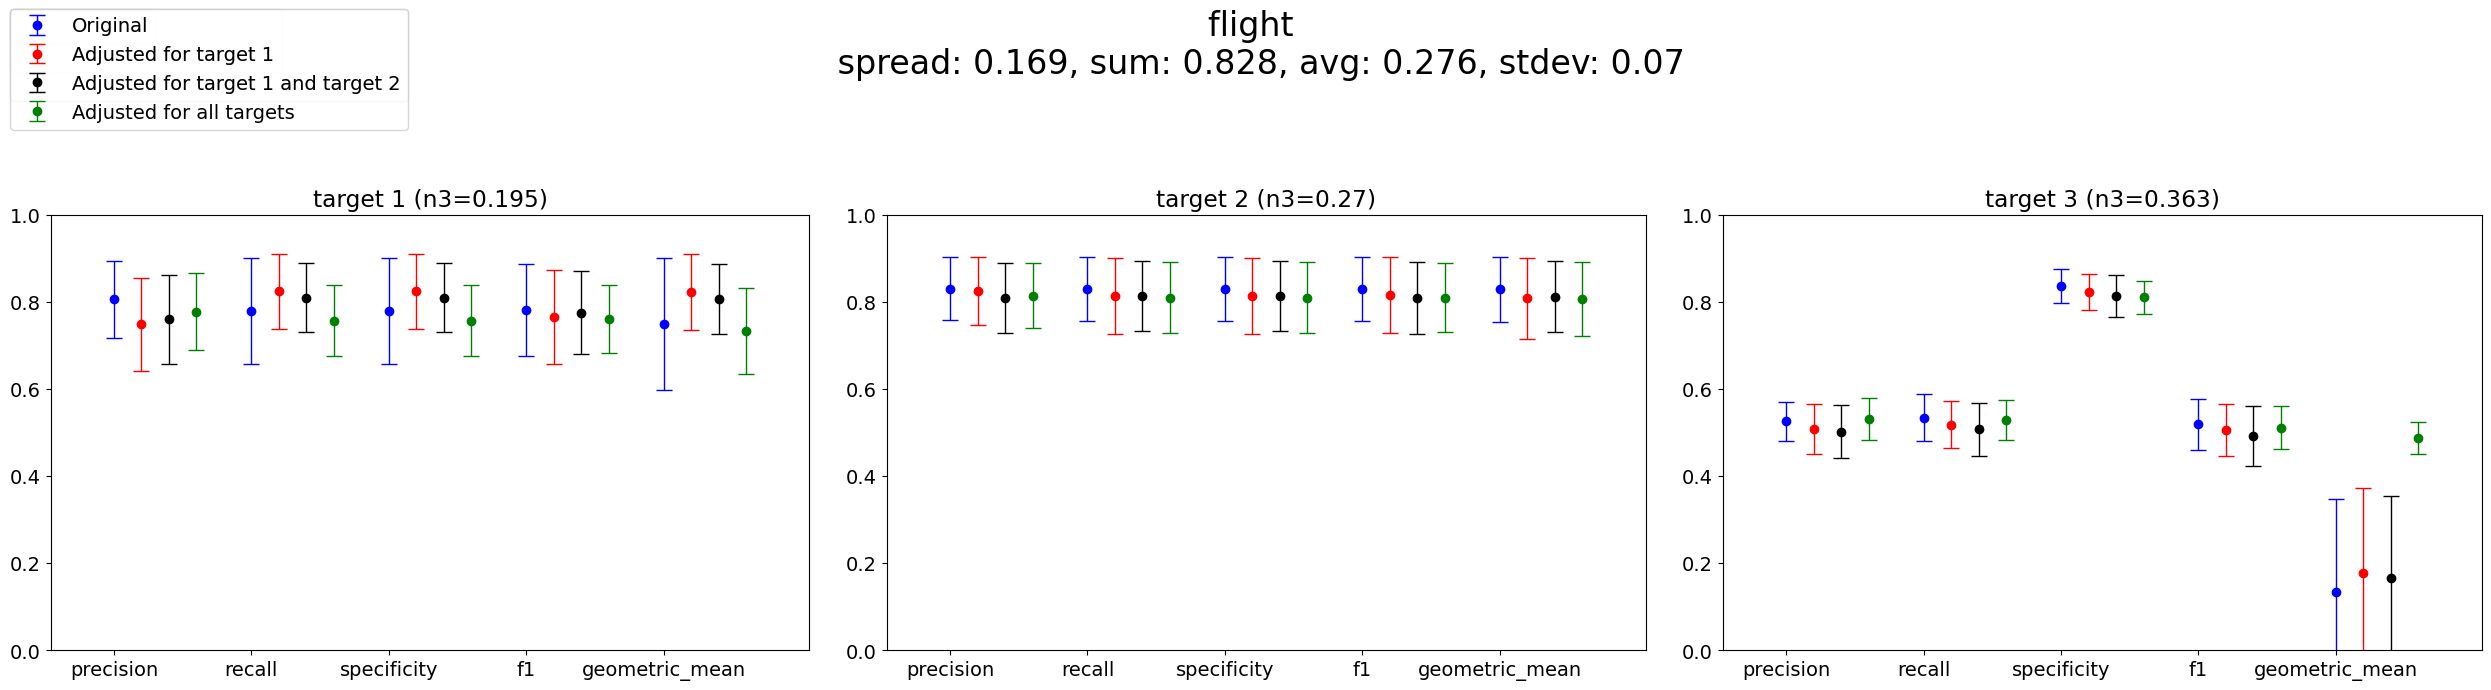

In [97]:
plt.rc('font', size=14) 

learners = list(aggregateMetrics.keys())
datasets = list(DATA_STRUCTURE.keys())
metrics = ['precision', 'recall', 'specificity', 'f1', 'geometric_mean']

datasetComplexities = dict()

for dataset in datasets:
  targetComplexities = list(finalComplexityDF.loc[finalComplexityDF['dataset']==dataset]['value'].values)
  datasetComplexities[dataset] = average(targetComplexities)

for dataset in datasets:
  fig, axs = plt.subplots(1, 3, constrained_layout=False)
  targetComplexities = list(finalComplexityDF.loc[finalComplexityDF['dataset']==dataset]['value'].values)
  # print(average(targetComplexities) + sum(targetComplexities))
  fig.suptitle(f"{dataset} \n spread: {round(max(targetComplexities)- min(targetComplexities), 3)  }, sum: {round(sum(targetComplexities), 3)}, avg: {round(average(targetComplexities),3)}, stdev: {round(np.std(np.array(targetComplexities)), 2)}", fontsize=24, y=1.35
  )
  fig.set_figwidth(25)
  fig.set_figheight(5)
  
  for j, modification in enumerate(allAggregatePerformances):
    allTargets = pd.DataFrame({})
    for x in allAggregatePerformances[modification][0]:
      df = allAggregatePerformances[modification][0][x]
      df['learner'] = x
      allTargets = pd.concat((allTargets, df.loc[df['dataset'] == dataset]), ignore_index=True)
    # print(modification, dataset)
    groupedMetrics = allTargets.groupby('target', as_index = False)[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean']].mean()
    groupedMetricsStdev = allTargets.groupby('target', as_index = False)[['avg_precision', 'avg_recall', 'avg_specificity', 'avg_f1', 'avg_geometric_mean']].std()

    
    for i in range(3):
      metricValues = list(groupedMetrics[groupedMetrics['target']== f'target{i+1}'].values[0][1:])
      stdevList = list(groupedMetricsStdev[groupedMetrics['target']== f'target{i+1}'].values[0][1:])
      left = Affine2D().translate(0.2*j, 0.0) + axs[i].transData
      axs[i].set(xmargin= 0.1, ylim=(0, 1))
      targetComplexity = list(finalComplexityDF.loc[finalComplexityDF['dataset']==dataset].loc[finalComplexityDF['Target']==f'target{i+1}'].values[0])[2]
      # print(targetComplexity, targetComplexities[i])
      axs[i].title.set_text(f'target {i+1} (n3={round(targetComplexities[i], 3)})')
      
      # axs[i].errorbar(metrics, metricValues, linewidth=1, fmt=allAggregatePerformances[modification][2], capsize=6, transform=transformation, label=AggregatePerformance)
      axs[i].errorbar(metrics, metricValues, yerr=stdevList, linewidth=1, fmt=allAggregatePerformances[modification][2], transform=left, label=modification, capsize=6)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left', fontsize='medium')
    plt.savefig(f'./figures/{dataset}.png',bbox_inches='tight')  